<a href="https://colab.research.google.com/github/NicoleLia/Model-Adv/blob/main/FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, ToTensor
from transformers import BertTokenizer
from collections import defaultdict
from sklearn.model_selection import train_test_split
import optuna
import torch.optim as optim

In [2]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [3]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.3 MB/s eta 0:00:00


In [7]:
!7z x /content/drive/MyDrive/Flickr8k.zip -o/content/data


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 1112971163 bytes (1062 MiB)

Extracting archive: /content/drive/MyDrive/Flickr8k.zip
 50% 4096 Open              --
Path = /content/drive/MyDrive/Flickr8k.zip
Type = zip
Physical Size = 1112971163

  0%      3% 248 - Images/1287982439_6578006e22.jpg                                             5% 465 - Images/143688283_a96ded20f1.jpg                                            8% 665 - Images/1683444418_815f660379.jpg

In [8]:
# initial
def load_data(captions_file, img_dir,test_size=0.1, val_size=0.1):
    df = pd.read_csv(captions_file)
    df['image'] = df['image'].apply(lambda x: os.path.join(img_dir, x))

    transform = Compose([
        Resize((224, 224)),
        ToTensor()
    ])

    xs = []
    ys = []

    for idx, row in df.iterrows():
        image = Image.open(row['image']).convert('RGB')
        caption = row['caption']

        image = transform(image)

        xs.append(image)
        ys.append(caption)

    # train: train dataset
    # val: adv dataset
    # test
    train_val_xs, test_xs, train_val_ys, test_ys = train_test_split(xs, ys, test_size=test_size, random_state=42)
    train_xs, val_xs, train_ys, val_ys = train_test_split(train_val_xs, train_val_ys, test_size=val_size / (1.0 - test_size), random_state=42)

    return (train_xs, train_ys), (val_xs, val_ys), (test_xs, test_ys)

img_dir = '/content/data/Flickr8k/Images'
captions_file = '/content/data/Flickr8k/captions.txt'
(train_xs, train_ys), (val_xs, val_ys), (test_xs, test_ys) = load_data(captions_file, img_dir)

print("Training data size:", len(train_xs))
print("Validation data size:", len(val_xs))
print("Test data size:", len(test_xs))

Training data size: 32363
Validation data size: 4046
Test data size: 4046


In [9]:
class Vocab:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.add_word('<unk>')
        self.add_word('<pad>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

vocab = Vocab()

In [10]:
# create instance
from torch.utils.data import Dataset

class Dataset(torch.utils.data.Dataset):
    def __init__(self, xs, ys, vocab):
        self.xs = xs
        self.ys = [torch.tensor([vocab(word) for word in y.split()], dtype=torch.long) for y in ys]
        self.vocab = vocab

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, index):
        return self.xs[index], self.ys[index]

train_dataset = Dataset(train_xs, train_ys, vocab)
val_dataset = Dataset(val_xs, val_ys, vocab)
test_dataset = Dataset(test_xs, test_ys, vocab)

x, y = train_dataset[0]
print("First item shape:", x.shape, "Caption:", y)

First item shape: torch.Size([3, 224, 224]) Caption: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [11]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab('<pad>'))
    return images, captions

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

for images, captions in train_loader:
    print(images.shape, captions)
    break

torch.Size([32, 3, 224, 224]) tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
import torch.nn as nn
from torchvision.models import resnet50

class VLM(nn.Module):
    def __init__(self, vocab_size):
        super(VLM, self).__init__()
        resnet = resnet50(pretrained=True)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_img = nn.Linear(2048, 512)  # 图像特征到嵌入维度

        self.embed = nn.Embedding(vocab_size, 512)  # 字幕嵌入层
        self.transformer = nn.Transformer(
            d_model=512,
            nhead=8,
            num_encoder_layers=3,
            num_decoder_layers=3
        )
        self.output_fc = nn.Linear(512, vocab_size)  # 输出层

    def forward(self, images, captions):
        img_features = self.resnet_features(images)
        img_features = self.avgpool(img_features)
        img_features = torch.flatten(img_features, 1)
        img_features = self.fc_img(img_features)

        caption_features = self.embed(captions)

        # 扩展图像特征维度以匹配字幕特征
        img_features = img_features.unsqueeze(1).expand(-1, captions.size(1), -1)
        caption_features = caption_features.transpose(0, 1)  # [seq_len, batch_size, embed_size]
        caption_features = caption_features.transpose(0, 1)  # 转换为 [batch_size, seq_len, embed_size]


        transformer_output = self.transformer(img_features, caption_features)
        output = self.output_fc(transformer_output)

        return output

In [38]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [75]:
def adversarial_training(model, device, train_loader, test_loader, optimizer, criterion, epsilon):
    model.train()
    epochs = 10
    for epoch in range(epochs):
        for images, captions in train_loader:
            images, captions = images.to(device), captions.to(device)
            images.requires_grad = True

            outputs = model(images, captions[:, :-1])
            print("Output grad_fn:", outputs.grad_fn)  # 检查梯度函数
            captions_target = captions[:, 1:].contiguous().view(-1)

            optimizer.zero_grad()
            loss = criterion(outputs.view(-1, outputs.size(-1)), captions_target)
            loss.backward()
            data_grad = images.grad.data

            perturbed_data = fgsm_attack(images, epsilon, data_grad)
            optimizer.zero_grad()
            outputs_perturbed = model(perturbed_data, captions[:, :-1])
            loss_perturbed = criterion(outputs_perturbed.view(-1, outputs_perturbed.size(-1)), captions_target)
            loss_perturbed.backward()
            optimizer.step()

            print(f"Epoch {epoch+1}, Loss: {loss.item()}")  # 打印每个epoch的损失

    model.eval()
    total = 0
    normal_correct = 0
    adversarial_correct = 0
    for images, captions in test_loader:
        images, captions = images.to(device), captions.to(device)
        captions_target = captions[:, 1:].contiguous().view(-1)

        outputs = model(images, captions[:, :-1])
        pred_normal = outputs.view(-1, outputs.size(-1)).argmax(dim=1)
        normal_correct += pred_normal.eq(captions_target).sum().item()

        images.requires_grad = True
        outputs = model(images, captions[:, :-1])
        outputs.backward(torch.ones_like(outputs))
        data_grad = images.grad.data
        perturbed_images = fgsm_attack(images, epsilon, data_grad)

        outputs_perturbed = model(perturbed_images, captions[:, :-1])
        pred_adversarial = outputs_perturbed.view(-1, outputs_perturbed.size(-1)).argmax(dim=1)
        adversarial_correct += pred_adversarial.eq(captions_target).sum().item()

        total += captions_target.size(0)

    print(f'Normal Accuracy: {normal_correct / total:.2%}')
    print(f'Adversarial Accuracy: {adversarial_correct / total:.2%}')


In [40]:
# adjust
def objective(trial):
    try:
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = VLM(len(vocab)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        loss = train(model, device, train_loader, optimizer, criterion, 10, scheduler=None, print_every=100, save_path='/content/model/model1')
        return loss
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('inf')


In [41]:
import matplotlib.pyplot as plt

In [42]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True)

In [43]:
def train(model, device, train_loader, optimizer, criterion, epochs, scheduler=None, print_every=100, save_path='/content/model/model1'):
    model.train()
    all_losses = []  # 记录所有损失以便绘图
    best_loss = float('inf')

    for epoch in range(epochs):
        total_loss = 0
        for i, (images, captions) in enumerate(train_loader):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])
            outputs = outputs.view(-1, outputs.size(-1))
            captions = captions[:, 1:].contiguous().view(-1)
            loss = criterion(outputs, captions)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if (i + 1) % print_every == 0:  # 每处理100个批次打印一次
                current_loss = total_loss / print_every
                all_losses.append(current_loss)  # 将当前计算的平均损失添加到列表
                print(f'Epoch {epoch+1}, Batch {i+1}, Partial Loss: {current_loss:.4f}')
                total_loss = 0  # 重置部分损失计数器


        if scheduler:
            scheduler.step()  # 更新学习率

        # 打印每个epoch的平均损失
        epoch_loss = sum(all_losses[-len(train_loader)//print_every:]) / (len(train_loader)//print_every)
        print(f'Epoch {epoch+1}, Total Loss: {epoch_loss:.4f}')

        if epoch_loss < best_loss:
          best_loss = epoch_loss
          torch.save(model.state_dict(), save_path)
          print(f"Model improved and saved to {save_path}")

        # 调用早停函数
        if early_stopping:
            early_stopping(epoch_loss, model, save_path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

    # 绘制损失图
    plt.figure(figsize=(12, 6))
    plt.plot(all_losses, marker='o', linestyle='-', color='b')
    plt.title('Model Loss During Training')
    plt.xlabel('Number of Batches Processed')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    return best_loss


In [44]:
def load_and_test(model, device, test_loader, criterion, model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions in test_loader:
            images, captions = images.to(device), captions.to(device)
            outputs = model(images, captions[:, :-1])
            outputs = outputs.view(-1, outputs.size(-1))
            captions = captions[:, 1:].contiguous().view(-1)
            loss = criterion(outputs, captions)
            total_loss += loss.item()
    average_loss = total_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')


[I 2024-07-21 03:46:36,100] A new study created in memory with name: no-name-1b252f44-eb25-4175-b682-2d936ae0ce82
<ipython-input-40-1ca8a31dcb82>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date wei

Epoch 1, Batch 100, Partial Loss: 0.2057
Epoch 1, Batch 200, Partial Loss: 0.1512
Epoch 1, Batch 300, Partial Loss: 0.1554
Epoch 1, Batch 400, Partial Loss: 0.1497
Epoch 1, Batch 500, Partial Loss: 0.1540
Epoch 1, Batch 600, Partial Loss: 0.1481
Epoch 1, Batch 700, Partial Loss: 0.1536
Epoch 1, Batch 800, Partial Loss: 0.1488
Epoch 1, Batch 900, Partial Loss: 0.1528
Epoch 1, Batch 1000, Partial Loss: 0.1515
Epoch 1, Batch 1100, Partial Loss: 0.1459
Epoch 1, Batch 1200, Partial Loss: 0.1502
Epoch 1, Batch 1300, Partial Loss: 0.1490
Epoch 1, Batch 1400, Partial Loss: 0.1491
Epoch 1, Batch 1500, Partial Loss: 0.1513
Epoch 1, Batch 1600, Partial Loss: 0.1493
Epoch 1, Batch 1700, Partial Loss: 0.1519
Epoch 1, Batch 1800, Partial Loss: 0.1472
Epoch 1, Batch 1900, Partial Loss: 0.1482
Epoch 1, Batch 2000, Partial Loss: 0.1524
Epoch 1, Total Loss: 0.1533
Model improved and saved to /content/model/model1
EarlyStopping counter: 3 out of 10
Early stopping


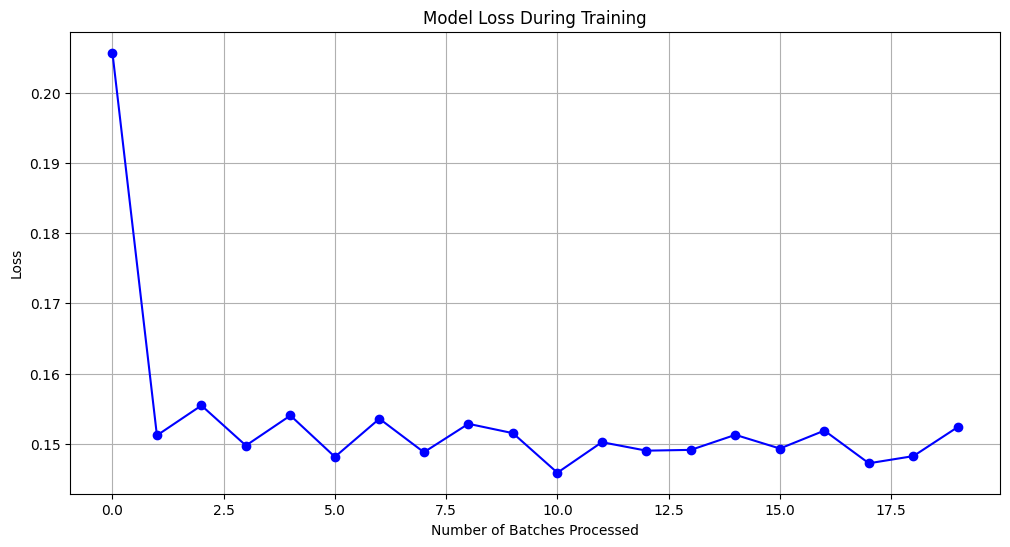

[I 2024-07-21 03:48:16,899] Trial 0 finished with value: 0.153266810297966 and parameters: {'lr': 4.1942749919717666e-05, 'batch_size': 16}. Best is trial 0 with value: 0.153266810297966.


Epoch 1, Batch 100, Partial Loss: 0.8388
Epoch 1, Batch 200, Partial Loss: 0.6873
Epoch 1, Batch 300, Partial Loss: 0.6861
Epoch 1, Batch 400, Partial Loss: 0.6980
Epoch 1, Batch 500, Partial Loss: 0.6880
Epoch 1, Batch 600, Partial Loss: 0.6814
Epoch 1, Batch 700, Partial Loss: 0.6838
Epoch 1, Batch 800, Partial Loss: 0.6802
Epoch 1, Batch 900, Partial Loss: 0.6750
Epoch 1, Batch 1000, Partial Loss: 0.6783
Epoch 1, Batch 1100, Partial Loss: 0.6773
Epoch 1, Batch 1200, Partial Loss: 0.6771
Epoch 1, Batch 1300, Partial Loss: 0.6779
Epoch 1, Batch 1400, Partial Loss: 0.6752
Epoch 1, Batch 1500, Partial Loss: 0.6809
Epoch 1, Batch 1600, Partial Loss: 0.6754
Epoch 1, Batch 1700, Partial Loss: 0.6784
Epoch 1, Batch 1800, Partial Loss: 0.6767
Epoch 1, Batch 1900, Partial Loss: 0.6790
Epoch 1, Batch 2000, Partial Loss: 0.6801
Epoch 1, Total Loss: 0.6887
Model improved and saved to /content/model/model1
EarlyStopping counter: 4 out of 10
Early stopping


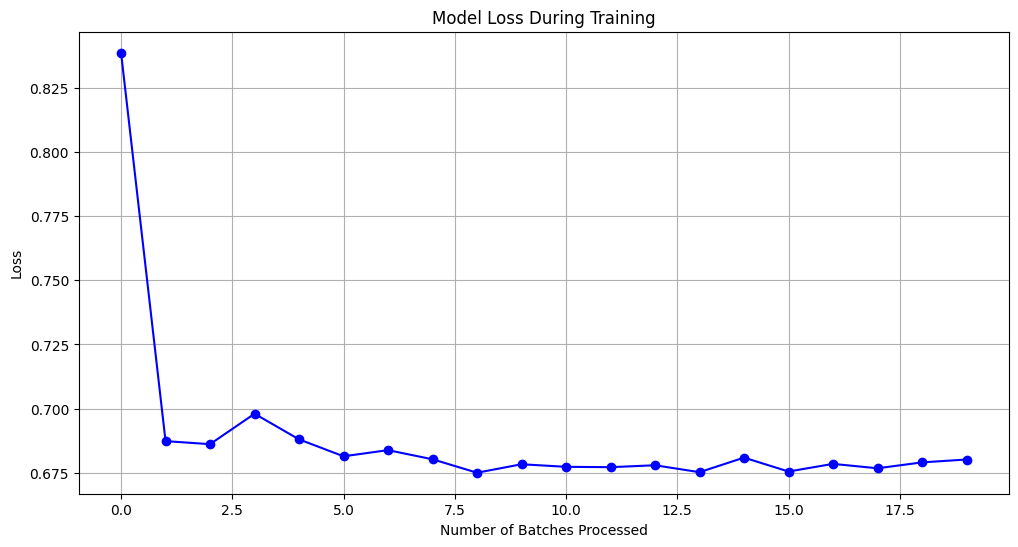

[I 2024-07-21 03:49:58,083] Trial 1 finished with value: 0.6887338467538358 and parameters: {'lr': 0.0013933392289850828, 'batch_size': 16}. Best is trial 0 with value: 0.153266810297966.


Epoch 1, Batch 100, Partial Loss: 0.8338
Epoch 1, Batch 200, Partial Loss: 0.6902
Epoch 1, Batch 300, Partial Loss: 0.6816
Epoch 1, Batch 400, Partial Loss: 0.6894
Epoch 1, Batch 500, Partial Loss: 0.6829
Epoch 1, Batch 600, Partial Loss: 0.6895
Epoch 1, Batch 700, Partial Loss: 0.6780
Epoch 1, Batch 800, Partial Loss: 0.6764
Epoch 1, Batch 900, Partial Loss: 0.6865
Epoch 1, Batch 1000, Partial Loss: 0.6784
Epoch 1, Batch 1100, Partial Loss: 0.6772
Epoch 1, Batch 1200, Partial Loss: 0.6769
Epoch 1, Batch 1300, Partial Loss: 0.6822
Epoch 1, Batch 1400, Partial Loss: 0.6784
Epoch 1, Batch 1500, Partial Loss: 0.6795
Epoch 1, Batch 1600, Partial Loss: 0.6808
Epoch 1, Batch 1700, Partial Loss: 0.6785
Epoch 1, Batch 1800, Partial Loss: 0.6791
Epoch 1, Batch 1900, Partial Loss: 0.6751
Epoch 1, Batch 2000, Partial Loss: 0.6834
Epoch 1, Total Loss: 0.6889
Model improved and saved to /content/model/model1
EarlyStopping counter: 5 out of 10
Early stopping


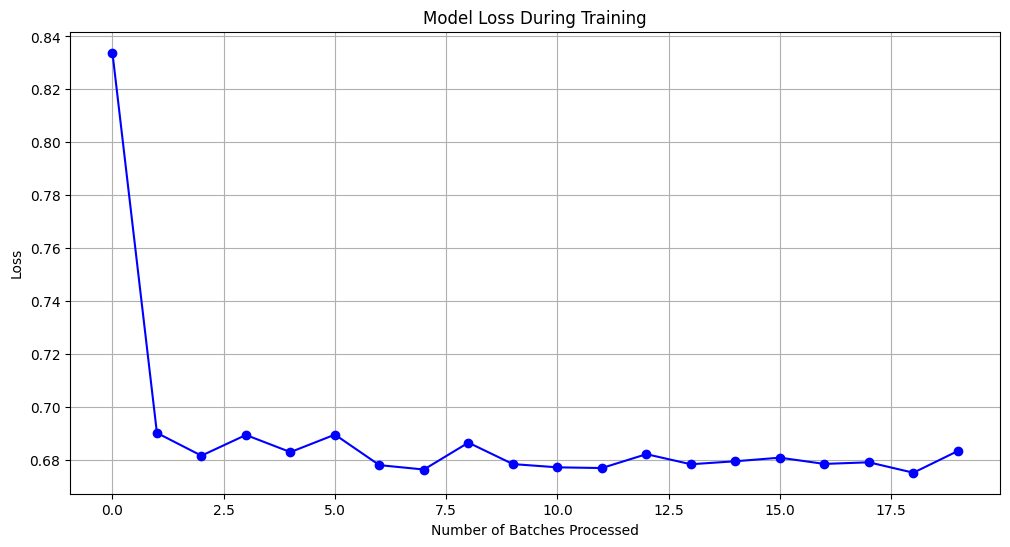

[I 2024-07-21 03:51:41,461] Trial 2 finished with value: 0.6888905444443225 and parameters: {'lr': 0.0018076251426933298, 'batch_size': 16}. Best is trial 0 with value: 0.153266810297966.


Epoch 1, Batch 100, Partial Loss: 1.0427
Epoch 1, Batch 200, Partial Loss: 0.7227
Epoch 1, Batch 300, Partial Loss: 0.7150
Epoch 1, Batch 400, Partial Loss: 0.6973
Epoch 1, Batch 500, Partial Loss: 0.6945
Epoch 1, Total Loss: 0.7745
Model improved and saved to /content/model/model1
EarlyStopping counter: 6 out of 10
Early stopping


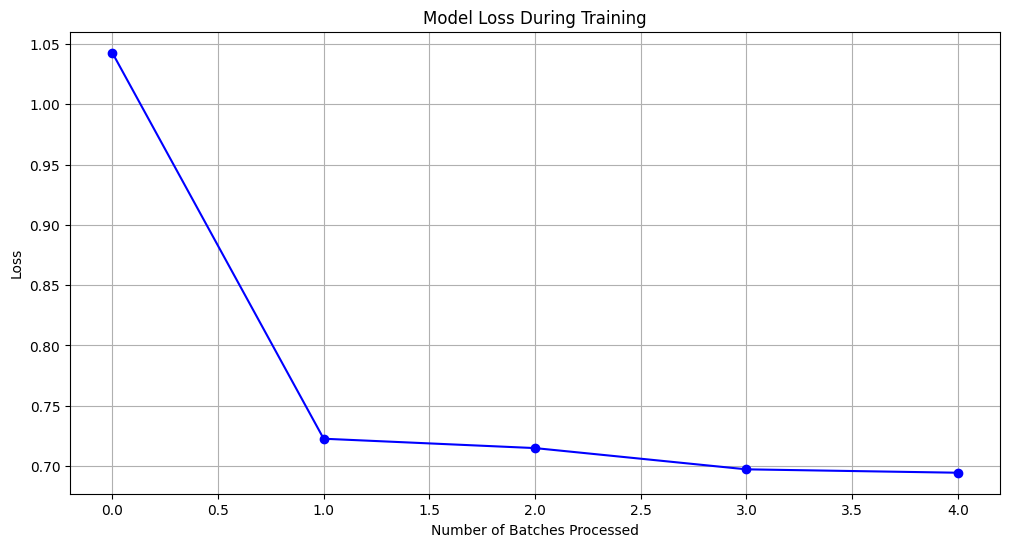

[I 2024-07-21 03:52:37,344] Trial 3 finished with value: 0.7744529209136963 and parameters: {'lr': 0.009472506776673209, 'batch_size': 64}. Best is trial 0 with value: 0.153266810297966.


Epoch 1, Batch 100, Partial Loss: 0.8510
Epoch 1, Batch 200, Partial Loss: 0.7172
Epoch 1, Batch 300, Partial Loss: 0.7023
Epoch 1, Batch 400, Partial Loss: 0.7146
Epoch 1, Batch 500, Partial Loss: 0.7028
Epoch 1, Total Loss: 0.7376
Model improved and saved to /content/model/model1
EarlyStopping counter: 7 out of 10
Early stopping


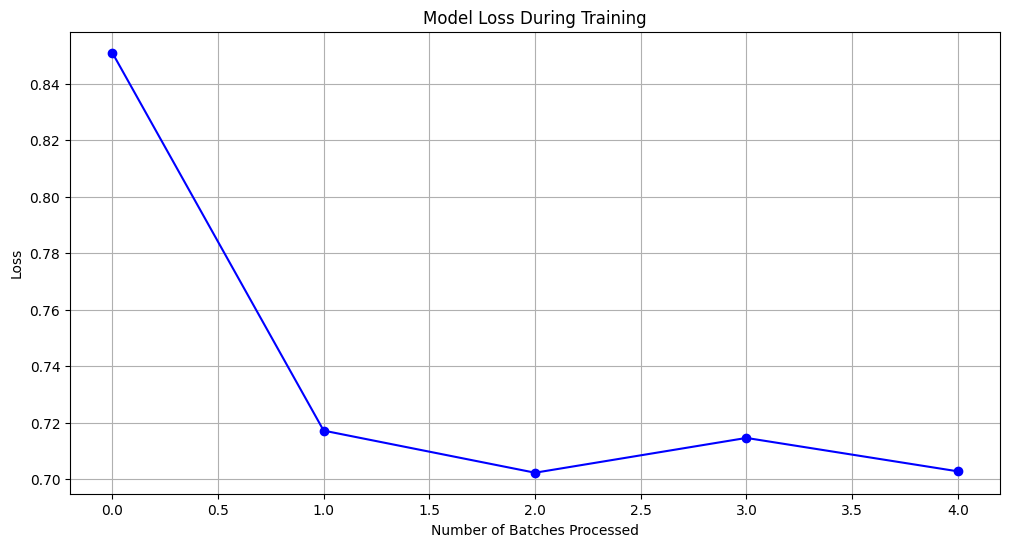

[I 2024-07-21 03:53:33,205] Trial 4 finished with value: 0.7376057617664337 and parameters: {'lr': 0.004132086977247002, 'batch_size': 64}. Best is trial 0 with value: 0.153266810297966.


Epoch 1, Batch 100, Partial Loss: 0.1771
Epoch 1, Batch 200, Partial Loss: 0.1410
Epoch 1, Batch 300, Partial Loss: 0.1366
Epoch 1, Batch 400, Partial Loss: 0.1355
Epoch 1, Batch 500, Partial Loss: 0.1365
Epoch 1, Batch 600, Partial Loss: 0.1355
Epoch 1, Batch 700, Partial Loss: 0.1406
Epoch 1, Batch 800, Partial Loss: 0.1356
Epoch 1, Batch 900, Partial Loss: 0.1423
Epoch 1, Batch 1000, Partial Loss: 0.1370
Epoch 1, Total Loss: 0.1418
Model improved and saved to /content/model/model1
EarlyStopping counter: 8 out of 10
Early stopping


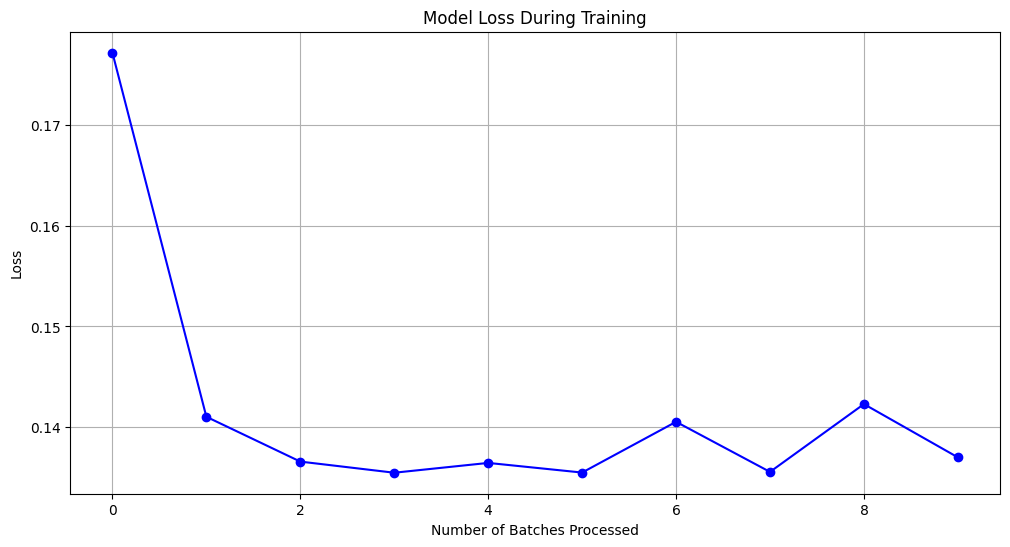

[I 2024-07-21 03:54:40,249] Trial 5 finished with value: 0.14177627559751277 and parameters: {'lr': 3.5233325394518005e-05, 'batch_size': 32}. Best is trial 5 with value: 0.14177627559751277.


Epoch 1, Batch 100, Partial Loss: 0.8294
Epoch 1, Batch 200, Partial Loss: 0.6998
Epoch 1, Batch 300, Partial Loss: 0.7074
Epoch 1, Batch 400, Partial Loss: 0.6978
Epoch 1, Batch 500, Partial Loss: 0.7011
Epoch 1, Batch 600, Partial Loss: 0.6910
Epoch 1, Batch 700, Partial Loss: 0.6941
Epoch 1, Batch 800, Partial Loss: 0.6914
Epoch 1, Batch 900, Partial Loss: 0.6912
Epoch 1, Batch 1000, Partial Loss: 0.6892
Epoch 1, Total Loss: 0.7092
Model improved and saved to /content/model/model1
EarlyStopping counter: 9 out of 10
Early stopping


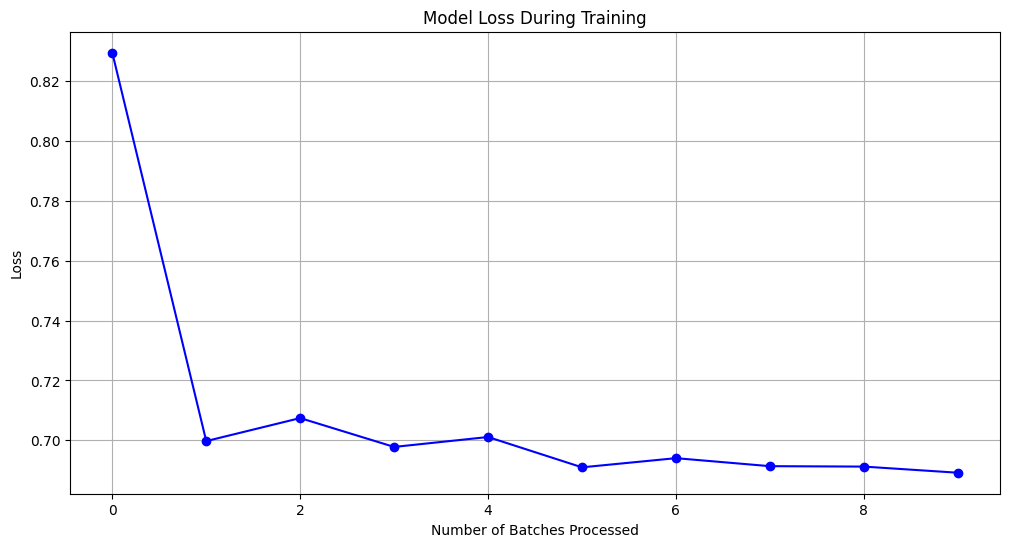

[I 2024-07-21 03:55:47,234] Trial 6 finished with value: 0.7092450050115585 and parameters: {'lr': 0.001845115814552867, 'batch_size': 32}. Best is trial 5 with value: 0.14177627559751277.


Epoch 1, Batch 100, Partial Loss: 0.2000
Epoch 1, Batch 200, Partial Loss: 0.1406
Epoch 1, Batch 300, Partial Loss: 0.1389
Epoch 1, Batch 400, Partial Loss: 0.1378
Epoch 1, Batch 500, Partial Loss: 0.1396
Epoch 1, Batch 600, Partial Loss: 0.1395
Epoch 1, Batch 700, Partial Loss: 0.1383
Epoch 1, Batch 800, Partial Loss: 0.1366
Epoch 1, Batch 900, Partial Loss: 0.1364
Epoch 1, Batch 1000, Partial Loss: 0.1367
Epoch 1, Total Loss: 0.1444
Model improved and saved to /content/model/model1
EarlyStopping counter: 10 out of 10
Early stopping


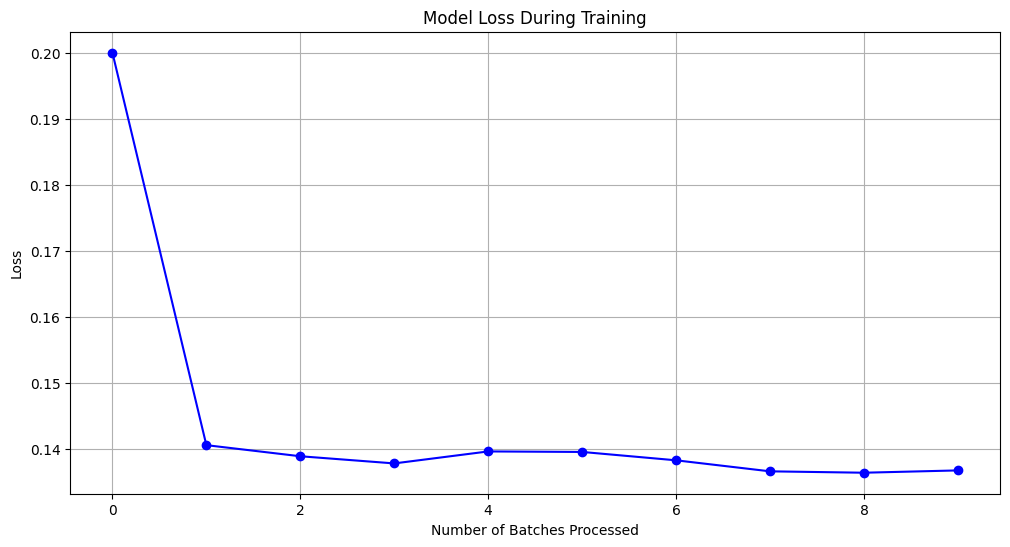

[I 2024-07-21 03:56:53,958] Trial 7 finished with value: 0.14444919848442078 and parameters: {'lr': 4.055465013674778e-05, 'batch_size': 32}. Best is trial 5 with value: 0.14177627559751277.


Epoch 1, Batch 100, Partial Loss: 0.1627
Epoch 1, Batch 200, Partial Loss: 0.1386
Epoch 1, Batch 300, Partial Loss: 0.1370
Epoch 1, Batch 400, Partial Loss: 0.1399
Epoch 1, Batch 500, Partial Loss: 0.1404
Epoch 1, Batch 600, Partial Loss: 0.1384
Epoch 1, Batch 700, Partial Loss: 0.1407
Epoch 1, Batch 800, Partial Loss: 0.1372
Epoch 1, Batch 900, Partial Loss: 0.1384
Epoch 1, Batch 1000, Partial Loss: 0.1391
Epoch 1, Total Loss: 0.1412
Model improved and saved to /content/model/model1
EarlyStopping counter: 11 out of 10
Early stopping


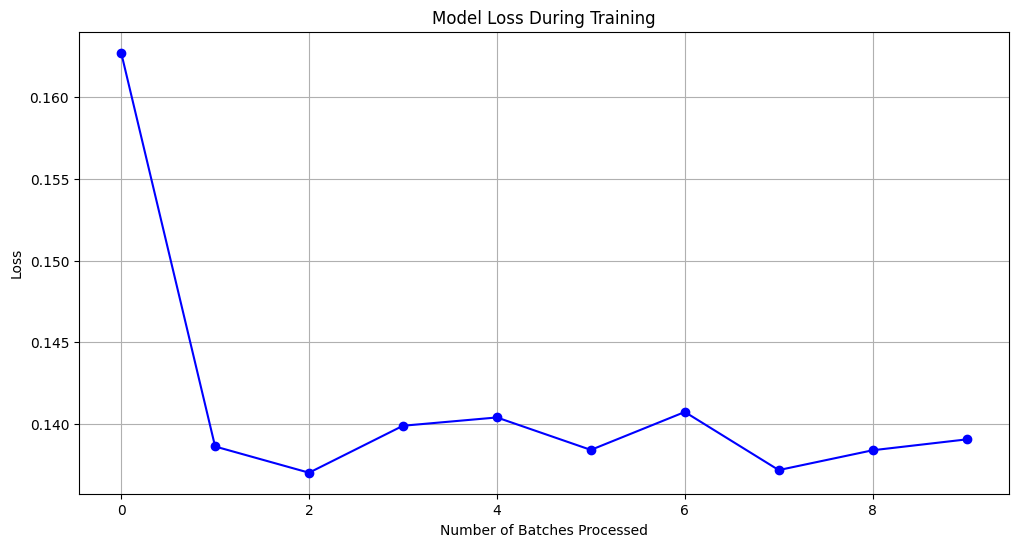

[I 2024-07-21 03:58:00,768] Trial 8 finished with value: 0.14124159132689237 and parameters: {'lr': 1.7178571193169735e-05, 'batch_size': 32}. Best is trial 8 with value: 0.14124159132689237.


Epoch 1, Batch 100, Partial Loss: 0.2256
Epoch 1, Batch 200, Partial Loss: 0.1385
Epoch 1, Batch 300, Partial Loss: 0.1380
Epoch 1, Batch 400, Partial Loss: 0.1385
Epoch 1, Batch 500, Partial Loss: 0.1353
Epoch 1, Batch 600, Partial Loss: 0.1385
Epoch 1, Batch 700, Partial Loss: 0.1387
Epoch 1, Batch 800, Partial Loss: 0.1395
Epoch 1, Batch 900, Partial Loss: 0.1398
Epoch 1, Batch 1000, Partial Loss: 0.1362
Epoch 1, Total Loss: 0.1469
Model improved and saved to /content/model/model1
EarlyStopping counter: 12 out of 10
Early stopping


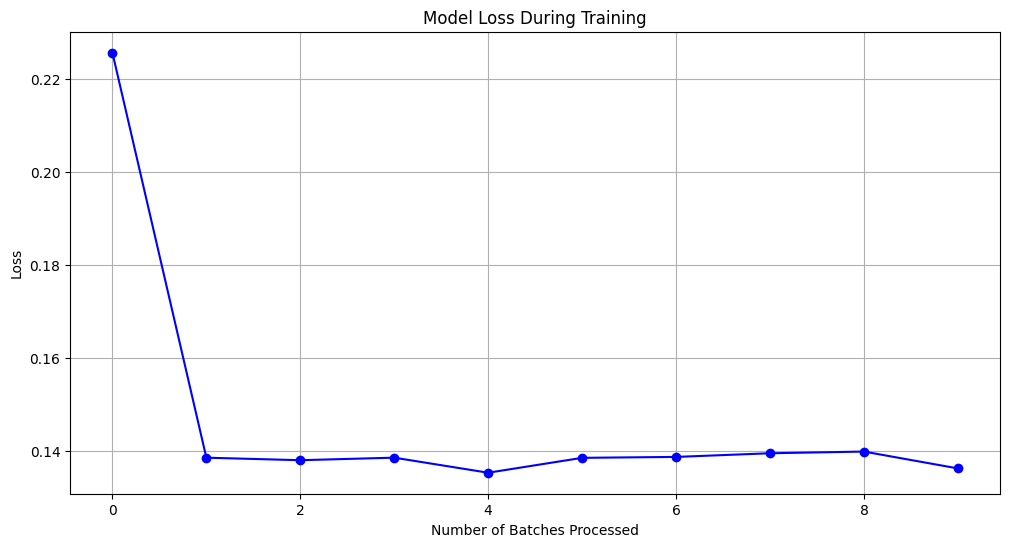

[I 2024-07-21 03:59:07,576] Trial 9 finished with value: 0.14685488729178903 and parameters: {'lr': 0.00032154637845775236, 'batch_size': 32}. Best is trial 8 with value: 0.14124159132689237.


Epoch 1, Batch 100, Partial Loss: 0.1720
Epoch 1, Batch 200, Partial Loss: 0.1426
Epoch 1, Batch 300, Partial Loss: 0.1428
Epoch 1, Batch 400, Partial Loss: 0.1423
Epoch 1, Batch 500, Partial Loss: 0.1398
Epoch 1, Batch 600, Partial Loss: 0.1391
Epoch 1, Batch 700, Partial Loss: 0.1363
Epoch 1, Batch 800, Partial Loss: 0.1385
Epoch 1, Batch 900, Partial Loss: 0.1359
Epoch 1, Batch 1000, Partial Loss: 0.1362
Epoch 1, Total Loss: 0.1425
Model improved and saved to /content/model/model1
EarlyStopping counter: 13 out of 10
Early stopping


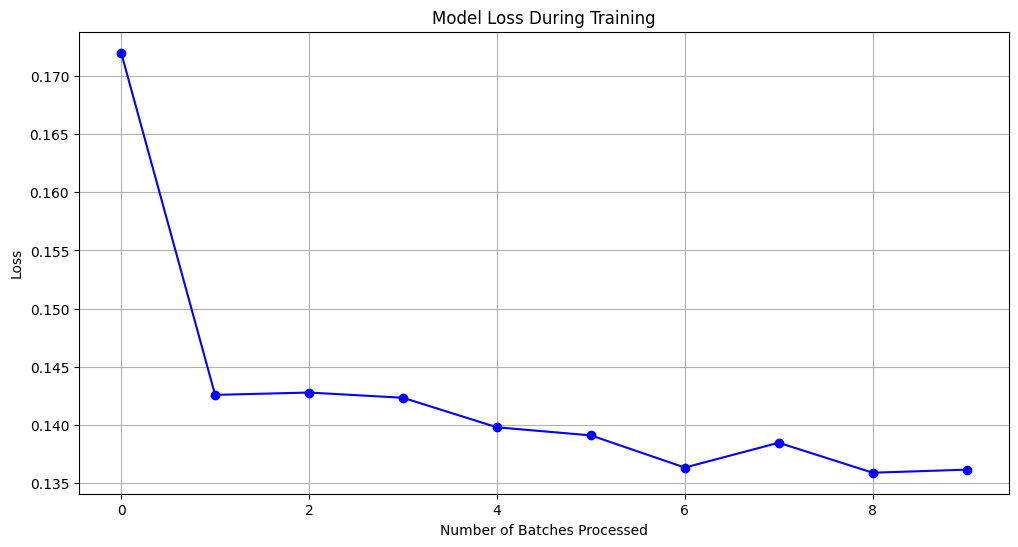

[I 2024-07-21 04:00:14,566] Trial 10 finished with value: 0.14254701133817438 and parameters: {'lr': 1.203245285980084e-05, 'batch_size': 32}. Best is trial 8 with value: 0.14124159132689237.


Epoch 1, Batch 100, Partial Loss: 0.1730
Epoch 1, Batch 200, Partial Loss: 0.1428
Epoch 1, Batch 300, Partial Loss: 0.1404
Epoch 1, Batch 400, Partial Loss: 0.1415
Epoch 1, Batch 500, Partial Loss: 0.1406
Epoch 1, Batch 600, Partial Loss: 0.1384
Epoch 1, Batch 700, Partial Loss: 0.1361
Epoch 1, Batch 800, Partial Loss: 0.1394
Epoch 1, Batch 900, Partial Loss: 0.1380
Epoch 1, Batch 1000, Partial Loss: 0.1404
Epoch 1, Total Loss: 0.1430
Model improved and saved to /content/model/model1
EarlyStopping counter: 14 out of 10
Early stopping


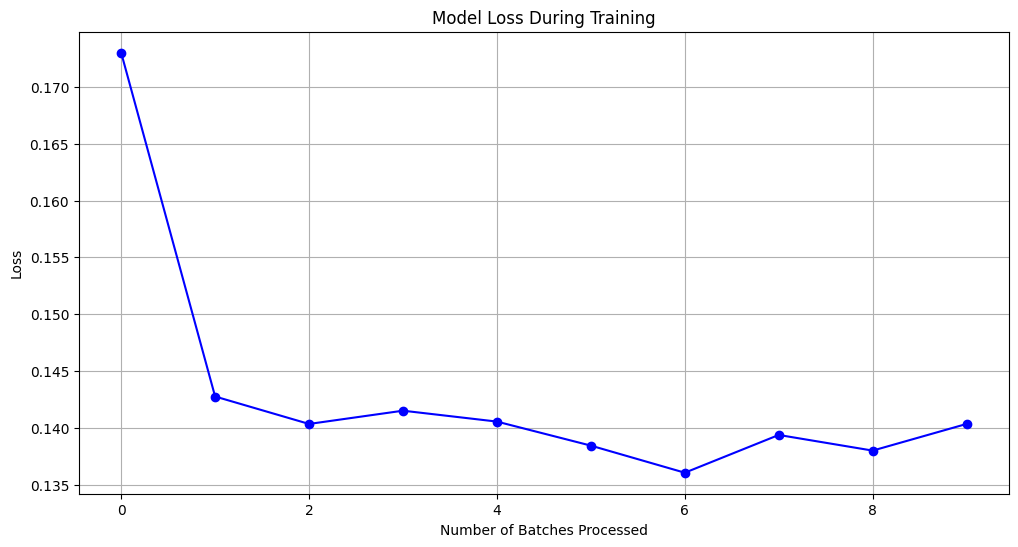

[I 2024-07-21 04:01:21,389] Trial 11 finished with value: 0.14304457617551086 and parameters: {'lr': 1.0282392206482316e-05, 'batch_size': 32}. Best is trial 8 with value: 0.14124159132689237.


Epoch 1, Batch 100, Partial Loss: 0.1634
Epoch 1, Batch 200, Partial Loss: 0.1390
Epoch 1, Batch 300, Partial Loss: 0.1346
Epoch 1, Batch 400, Partial Loss: 0.1389
Epoch 1, Batch 500, Partial Loss: 0.1413
Epoch 1, Batch 600, Partial Loss: 0.1408
Epoch 1, Batch 700, Partial Loss: 0.1374
Epoch 1, Batch 800, Partial Loss: 0.1367
Epoch 1, Batch 900, Partial Loss: 0.1381
Epoch 1, Batch 1000, Partial Loss: 0.1372
Epoch 1, Total Loss: 0.1407
Model improved and saved to /content/model/model1
EarlyStopping counter: 15 out of 10
Early stopping


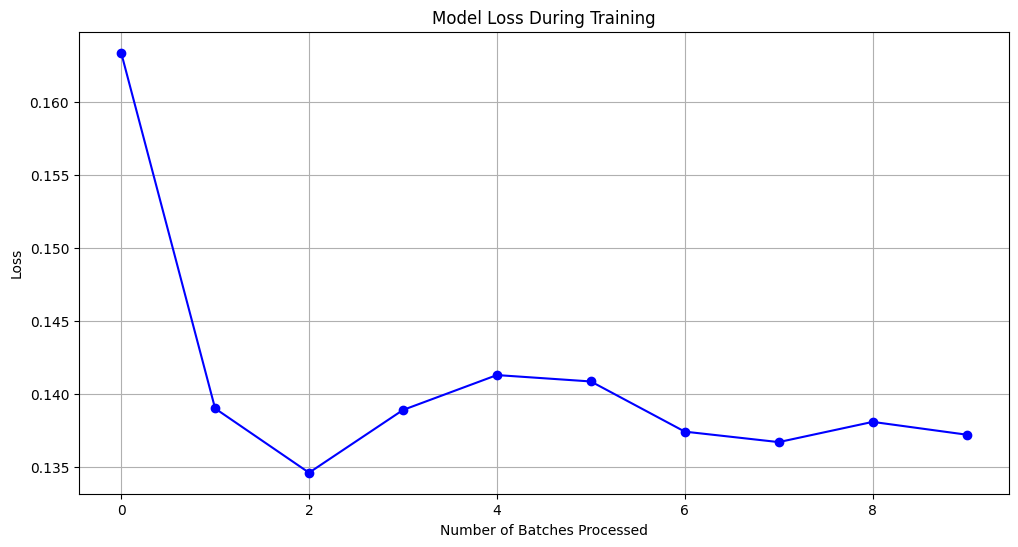

[I 2024-07-21 04:02:28,364] Trial 12 finished with value: 0.14072149332612754 and parameters: {'lr': 6.685373673793508e-05, 'batch_size': 32}. Best is trial 12 with value: 0.14072149332612754.


Epoch 1, Batch 100, Partial Loss: 0.2055
Epoch 1, Batch 200, Partial Loss: 0.1367
Epoch 1, Batch 300, Partial Loss: 0.1360
Epoch 1, Batch 400, Partial Loss: 0.1369
Epoch 1, Batch 500, Partial Loss: 0.1399
Epoch 1, Batch 600, Partial Loss: 0.1431
Epoch 1, Batch 700, Partial Loss: 0.1380
Epoch 1, Batch 800, Partial Loss: 0.1376
Epoch 1, Batch 900, Partial Loss: 0.1371
Epoch 1, Batch 1000, Partial Loss: 0.1371
Epoch 1, Total Loss: 0.1448
Model improved and saved to /content/model/model1
EarlyStopping counter: 16 out of 10
Early stopping


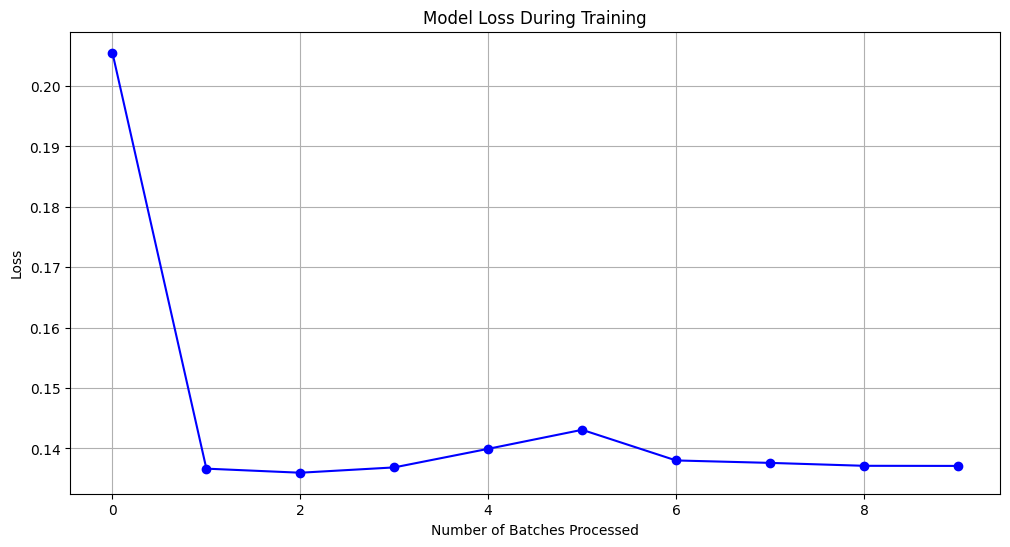

[I 2024-07-21 04:03:35,018] Trial 13 finished with value: 0.14478812077641487 and parameters: {'lr': 0.00018664290098967395, 'batch_size': 32}. Best is trial 12 with value: 0.14072149332612754.


Epoch 1, Batch 100, Partial Loss: 0.1674
Epoch 1, Batch 200, Partial Loss: 0.1291
Epoch 1, Batch 300, Partial Loss: 0.1258
Epoch 1, Batch 400, Partial Loss: 0.1261
Epoch 1, Batch 500, Partial Loss: 0.1271
Epoch 1, Total Loss: 0.1351
Model improved and saved to /content/model/model1
EarlyStopping counter: 17 out of 10
Early stopping


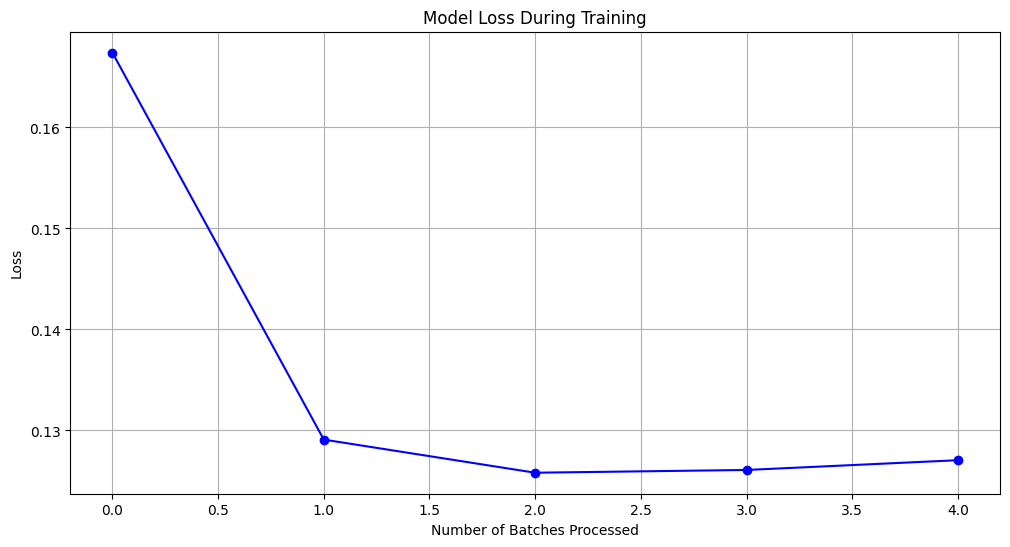

[I 2024-07-21 04:04:31,187] Trial 14 finished with value: 0.13508680850267413 and parameters: {'lr': 0.00014996331148354339, 'batch_size': 64}. Best is trial 14 with value: 0.13508680850267413.


Epoch 1, Batch 100, Partial Loss: 0.1763
Epoch 1, Batch 200, Partial Loss: 0.1264
Epoch 1, Batch 300, Partial Loss: 0.1256
Epoch 1, Batch 400, Partial Loss: 0.1269
Epoch 1, Batch 500, Partial Loss: 0.1305
Epoch 1, Total Loss: 0.1371
Model improved and saved to /content/model/model1
EarlyStopping counter: 18 out of 10
Early stopping


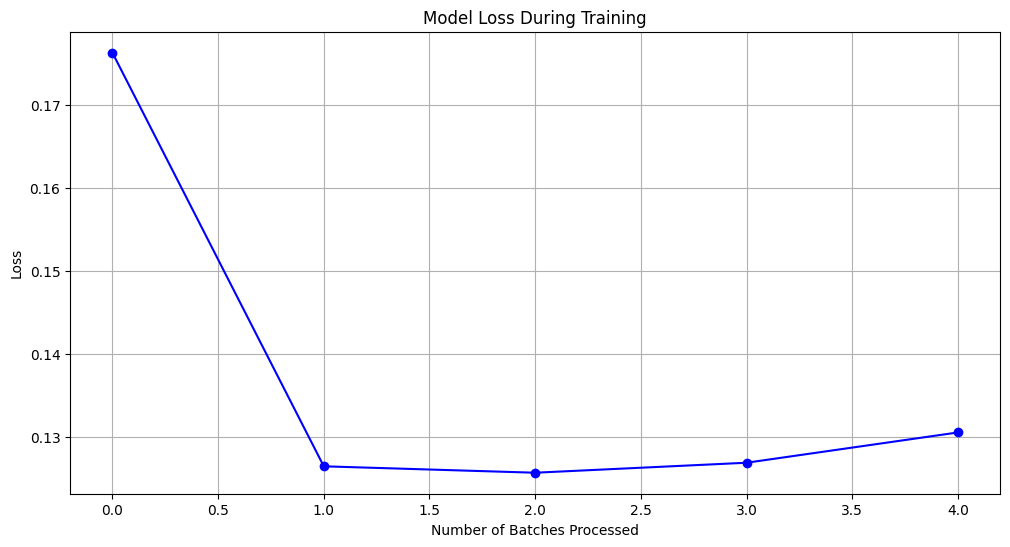

[I 2024-07-21 04:05:26,976] Trial 15 finished with value: 0.1371431480497122 and parameters: {'lr': 0.00014118280615548636, 'batch_size': 64}. Best is trial 14 with value: 0.13508680850267413.


Epoch 1, Batch 100, Partial Loss: 0.2077
Epoch 1, Batch 200, Partial Loss: 0.1296
Epoch 1, Batch 300, Partial Loss: 0.1271
Epoch 1, Batch 400, Partial Loss: 0.1283
Epoch 1, Batch 500, Partial Loss: 0.1272
Epoch 1, Total Loss: 0.1440
Model improved and saved to /content/model/model1
EarlyStopping counter: 19 out of 10
Early stopping


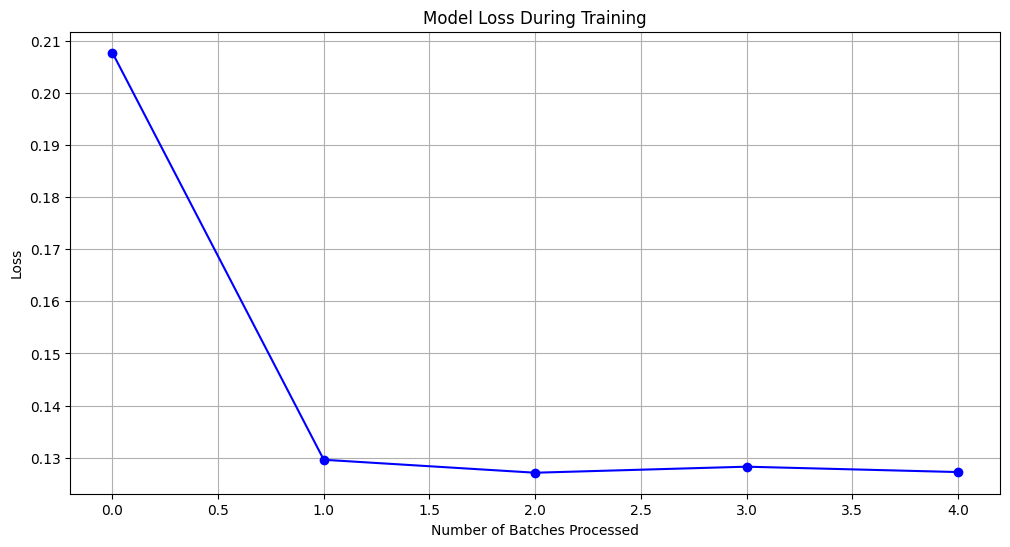

[I 2024-07-21 04:06:22,964] Trial 16 finished with value: 0.14397732824087145 and parameters: {'lr': 0.0002542210290325551, 'batch_size': 64}. Best is trial 14 with value: 0.13508680850267413.


Epoch 1, Batch 100, Partial Loss: 0.1804
Epoch 1, Batch 200, Partial Loss: 0.1286
Epoch 1, Batch 300, Partial Loss: 0.1256
Epoch 1, Batch 400, Partial Loss: 0.1294
Epoch 1, Batch 500, Partial Loss: 0.1259
Epoch 1, Total Loss: 0.1380
Model improved and saved to /content/model/model1
EarlyStopping counter: 20 out of 10
Early stopping


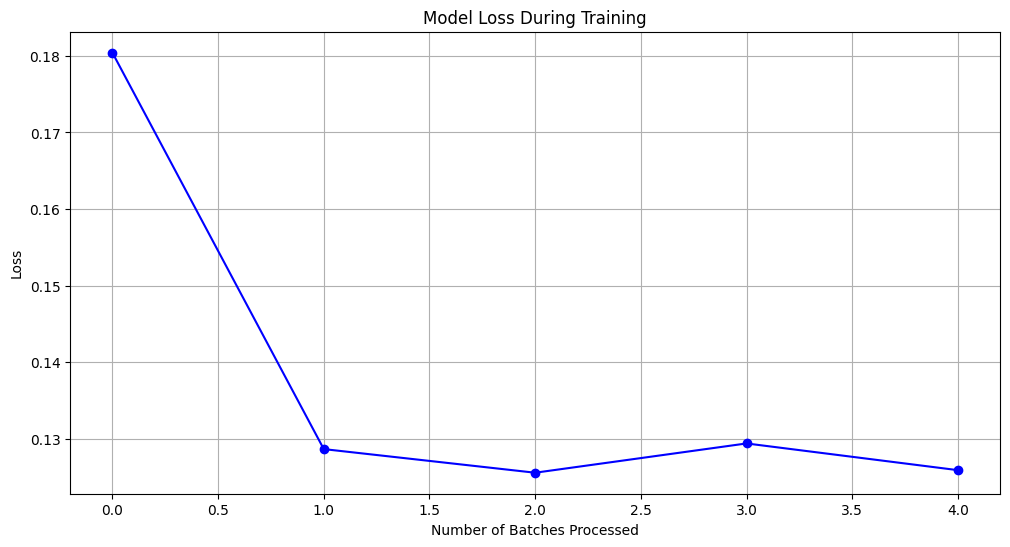

[I 2024-07-21 04:07:18,615] Trial 17 finished with value: 0.13797938311100005 and parameters: {'lr': 0.0001292493282863956, 'batch_size': 64}. Best is trial 14 with value: 0.13508680850267413.


Epoch 1, Batch 100, Partial Loss: 0.2649
Epoch 1, Batch 200, Partial Loss: 0.1262
Epoch 1, Batch 300, Partial Loss: 0.1288
Epoch 1, Batch 400, Partial Loss: 0.1291
Epoch 1, Batch 500, Partial Loss: 0.1267
Epoch 1, Total Loss: 0.1552
Model improved and saved to /content/model/model1
EarlyStopping counter: 21 out of 10
Early stopping


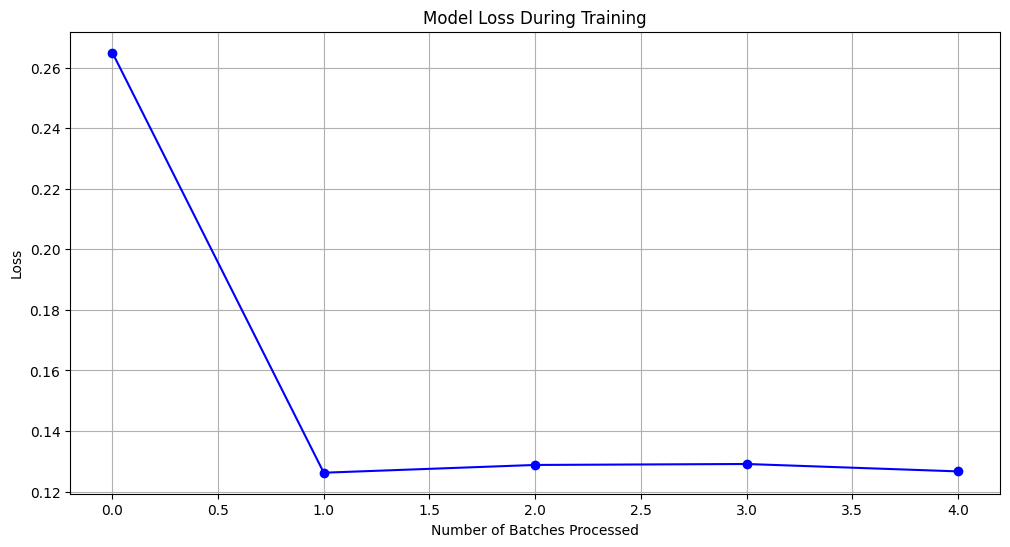

[I 2024-07-21 04:08:14,504] Trial 18 finished with value: 0.1551556159853935 and parameters: {'lr': 0.0006022468273257632, 'batch_size': 64}. Best is trial 14 with value: 0.13508680850267413.


Epoch 1, Batch 100, Partial Loss: 0.2535
Epoch 1, Batch 200, Partial Loss: 0.1269
Epoch 1, Batch 300, Partial Loss: 0.1276
Epoch 1, Batch 400, Partial Loss: 0.1287
Epoch 1, Batch 500, Partial Loss: 0.1267
Epoch 1, Total Loss: 0.1527
Model improved and saved to /content/model/model1
EarlyStopping counter: 22 out of 10
Early stopping


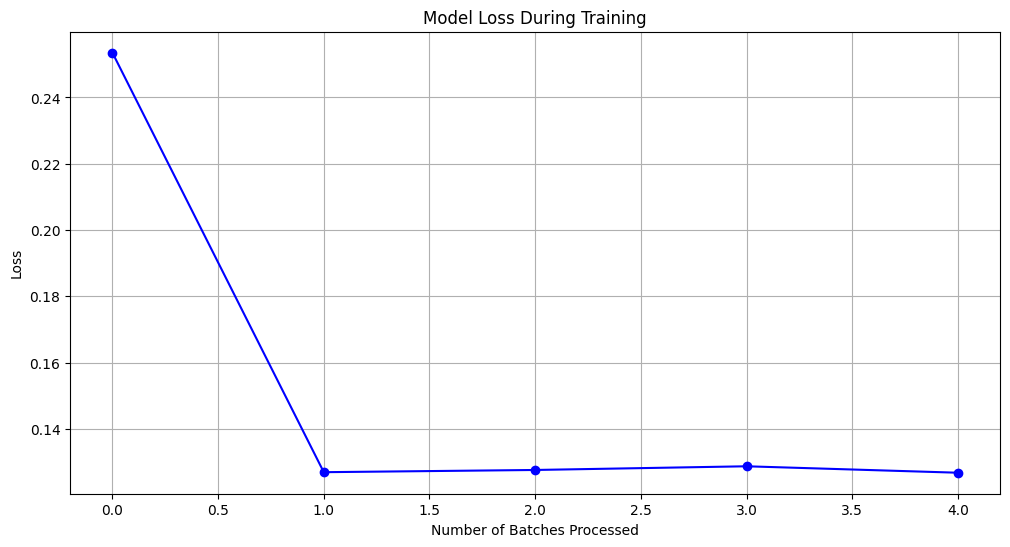

[I 2024-07-21 04:09:10,349] Trial 19 finished with value: 0.15267300012707713 and parameters: {'lr': 0.0005334043422229047, 'batch_size': 64}. Best is trial 14 with value: 0.13508680850267413.


Epoch 1, Batch 100, Partial Loss: 0.1654
Epoch 1, Batch 200, Partial Loss: 0.1266
Epoch 1, Batch 300, Partial Loss: 0.1277
Epoch 1, Batch 400, Partial Loss: 0.1276
Epoch 1, Batch 500, Partial Loss: 0.1283
Epoch 1, Total Loss: 0.1351
Model improved and saved to /content/model/model1
EarlyStopping counter: 23 out of 10
Early stopping


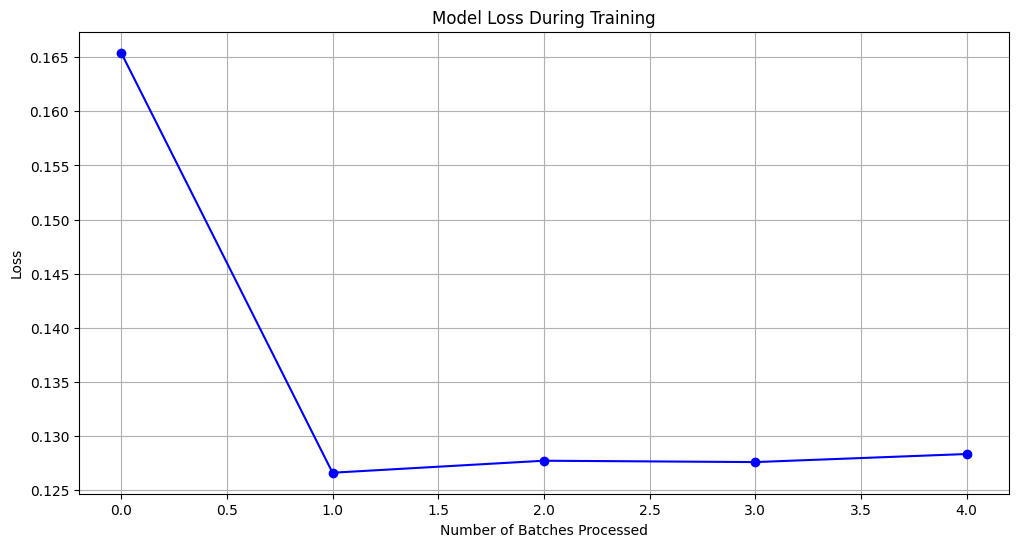

[I 2024-07-21 04:10:06,029] Trial 20 finished with value: 0.13513504791259767 and parameters: {'lr': 9.900106880800036e-05, 'batch_size': 64}. Best is trial 14 with value: 0.13508680850267413.


Epoch 1, Batch 100, Partial Loss: 0.1833
Epoch 1, Batch 200, Partial Loss: 0.1263
Epoch 1, Batch 300, Partial Loss: 0.1265
Epoch 1, Batch 400, Partial Loss: 0.1286
Epoch 1, Batch 500, Partial Loss: 0.1279
Epoch 1, Total Loss: 0.1385
Model improved and saved to /content/model/model1
EarlyStopping counter: 24 out of 10
Early stopping


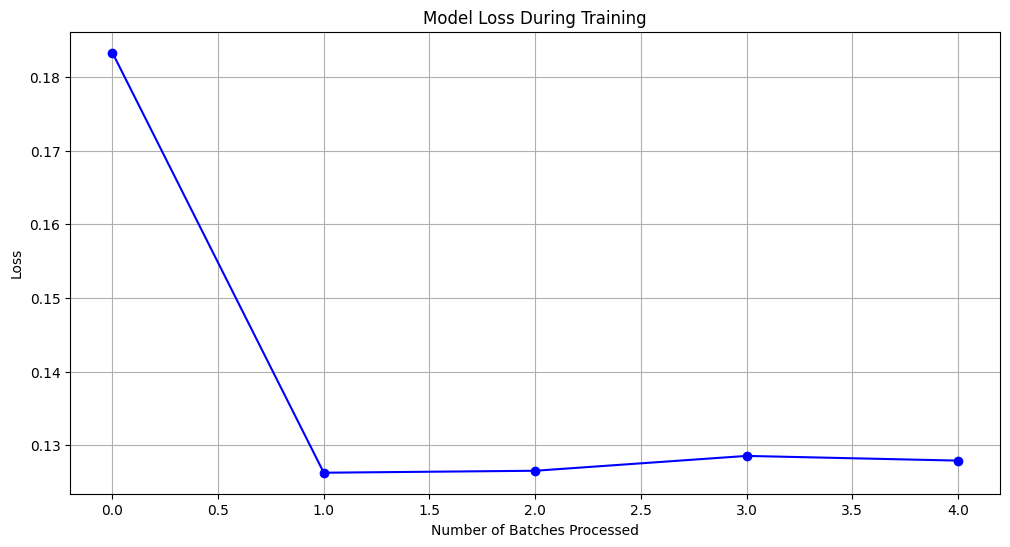

[I 2024-07-21 04:11:01,680] Trial 21 finished with value: 0.13851776592433454 and parameters: {'lr': 9.509969084673459e-05, 'batch_size': 64}. Best is trial 14 with value: 0.13508680850267413.


Epoch 1, Batch 100, Partial Loss: 0.1653
Epoch 1, Batch 200, Partial Loss: 0.1272
Epoch 1, Batch 300, Partial Loss: 0.1262
Epoch 1, Batch 400, Partial Loss: 0.1254
Epoch 1, Batch 500, Partial Loss: 0.1266
Epoch 1, Total Loss: 0.1342
Model improved and saved to /content/model/model1
EarlyStopping counter: 25 out of 10
Early stopping


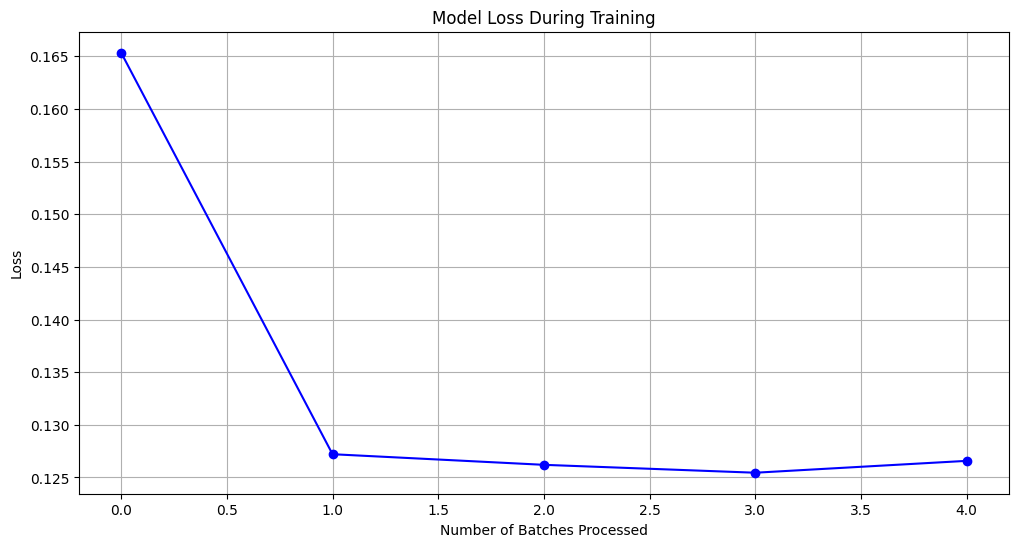

[I 2024-07-21 04:11:57,480] Trial 22 finished with value: 0.13415452924370766 and parameters: {'lr': 9.297540342041998e-05, 'batch_size': 64}. Best is trial 22 with value: 0.13415452924370766.


Epoch 1, Batch 100, Partial Loss: 0.1561
Epoch 1, Batch 200, Partial Loss: 0.1256
Epoch 1, Batch 300, Partial Loss: 0.1286
Epoch 1, Batch 400, Partial Loss: 0.1281
Epoch 1, Batch 500, Partial Loss: 0.1275
Epoch 1, Total Loss: 0.1332
Model improved and saved to /content/model/model1
EarlyStopping counter: 26 out of 10
Early stopping


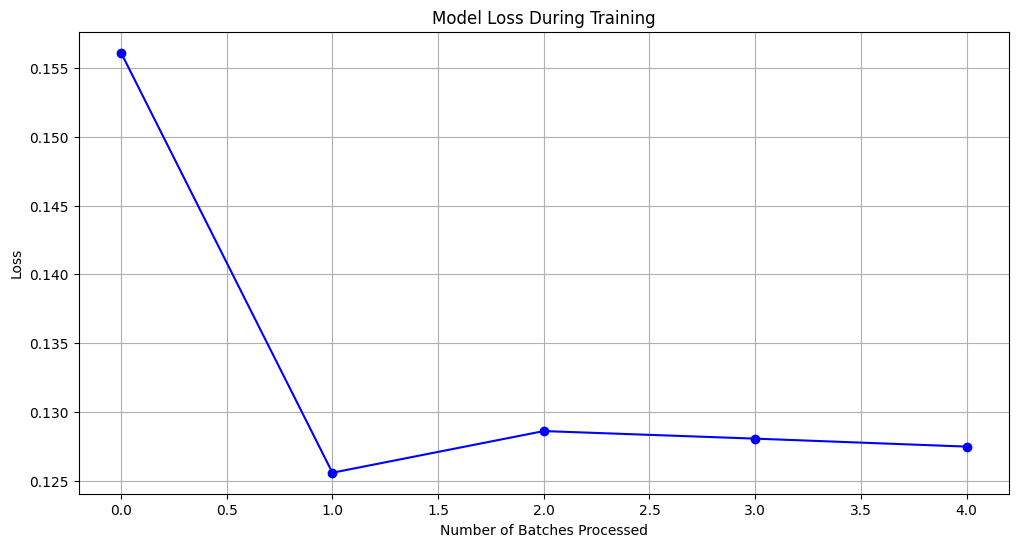

[I 2024-07-21 04:12:53,297] Trial 23 finished with value: 0.13316723524034024 and parameters: {'lr': 7.153914503656682e-05, 'batch_size': 64}. Best is trial 23 with value: 0.13316723524034024.


Epoch 1, Batch 100, Partial Loss: 0.1510
Epoch 1, Batch 200, Partial Loss: 0.1279
Epoch 1, Batch 300, Partial Loss: 0.1279
Epoch 1, Batch 400, Partial Loss: 0.1294
Epoch 1, Batch 500, Partial Loss: 0.1263
Epoch 1, Total Loss: 0.1325
Model improved and saved to /content/model/model1
EarlyStopping counter: 27 out of 10
Early stopping


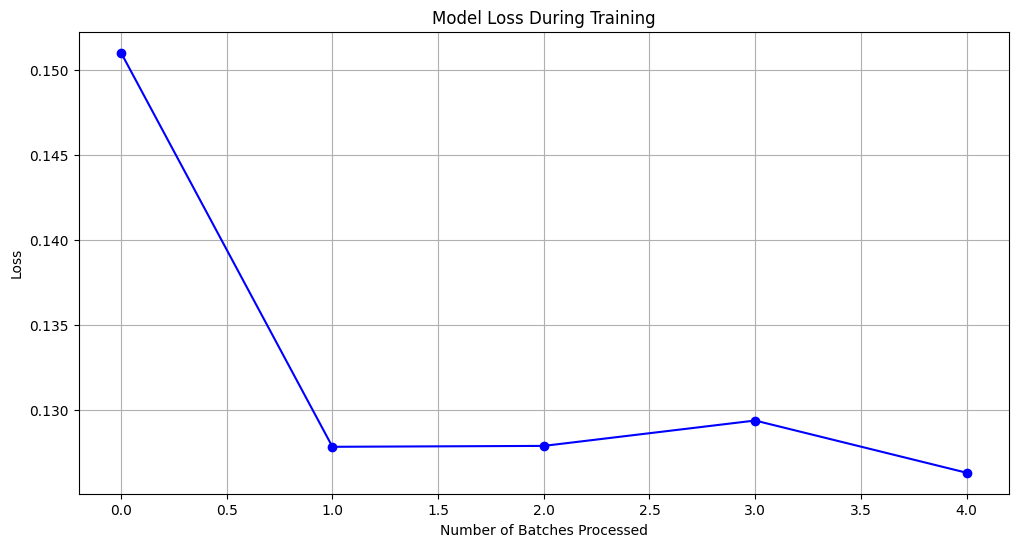

[I 2024-07-21 04:13:49,014] Trial 24 finished with value: 0.1325044887661934 and parameters: {'lr': 2.149778138258468e-05, 'batch_size': 64}. Best is trial 24 with value: 0.1325044887661934.


Epoch 1, Batch 100, Partial Loss: 0.1472
Epoch 1, Batch 200, Partial Loss: 0.1272
Epoch 1, Batch 300, Partial Loss: 0.1274
Epoch 1, Batch 400, Partial Loss: 0.1289
Epoch 1, Batch 500, Partial Loss: 0.1286
Epoch 1, Total Loss: 0.1319
Model improved and saved to /content/model/model1
Validation loss decreased (0.132452 --> 0.131862).  Saving model ...
Early stopping


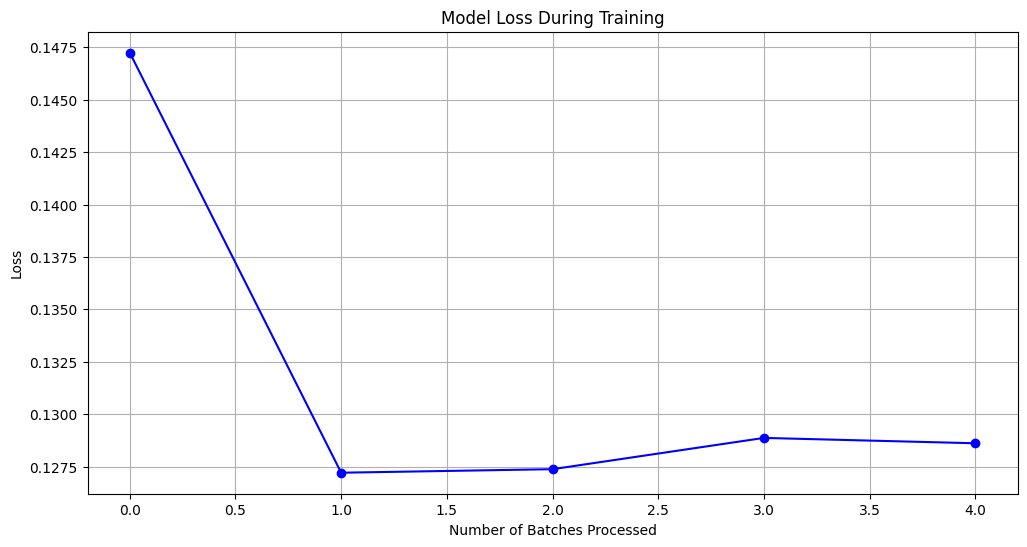

[I 2024-07-21 04:14:45,220] Trial 25 finished with value: 0.13186235968768595 and parameters: {'lr': 2.610438821394329e-05, 'batch_size': 64}. Best is trial 25 with value: 0.13186235968768595.


Epoch 1, Batch 100, Partial Loss: 0.1606
Epoch 1, Batch 200, Partial Loss: 0.1268
Epoch 1, Batch 300, Partial Loss: 0.1279
Epoch 1, Batch 400, Partial Loss: 0.1251
Epoch 1, Batch 500, Partial Loss: 0.1291
Epoch 1, Total Loss: 0.1339
Model improved and saved to /content/model/model1
EarlyStopping counter: 1 out of 10
Early stopping


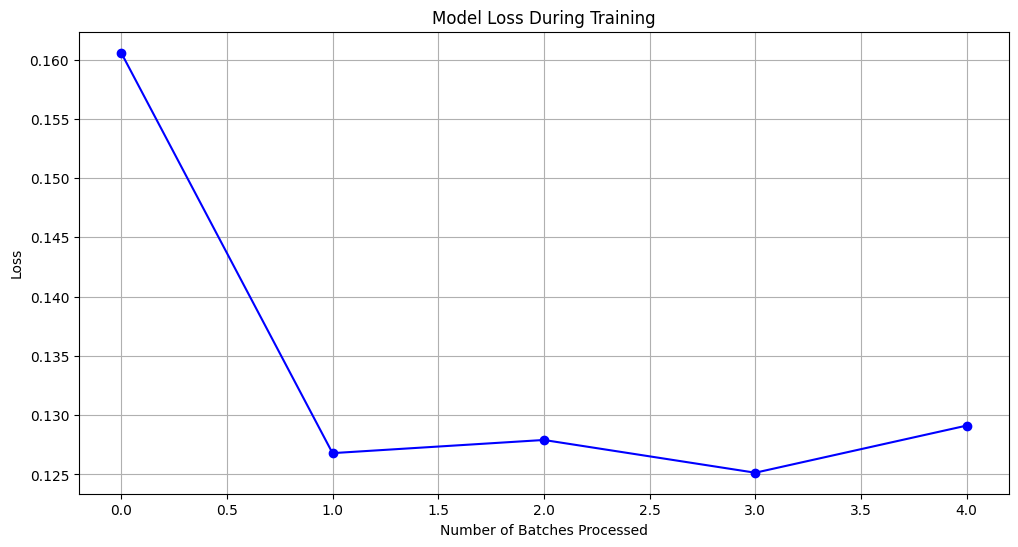

[I 2024-07-21 04:15:41,197] Trial 26 finished with value: 0.13390724091231823 and parameters: {'lr': 2.384521104255677e-05, 'batch_size': 64}. Best is trial 25 with value: 0.13186235968768595.


Epoch 1, Batch 100, Partial Loss: 0.1600
Epoch 1, Batch 200, Partial Loss: 0.1284
Epoch 1, Batch 300, Partial Loss: 0.1274
Epoch 1, Batch 400, Partial Loss: 0.1268
Epoch 1, Batch 500, Partial Loss: 0.1277
Epoch 1, Total Loss: 0.1341
Model improved and saved to /content/model/model1
EarlyStopping counter: 2 out of 10
Early stopping


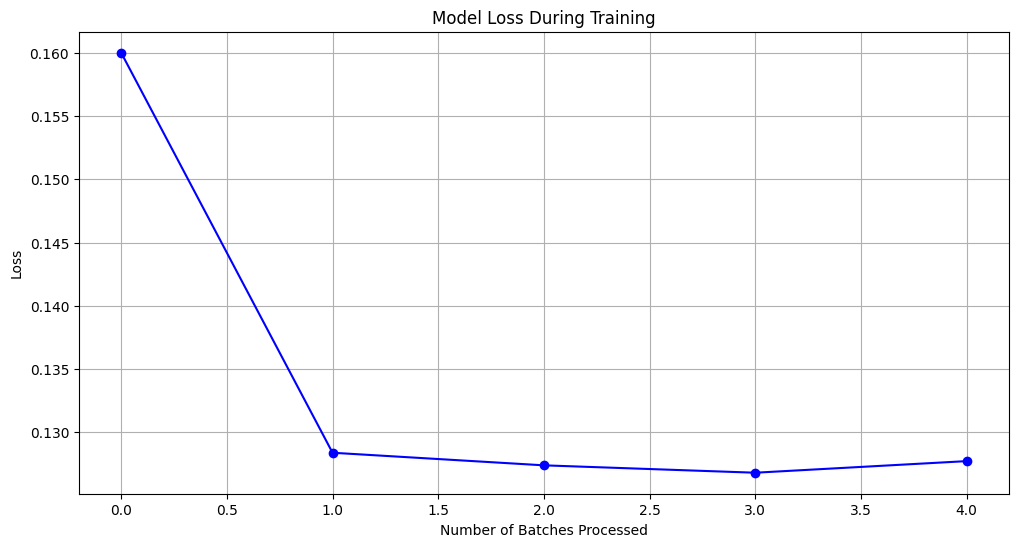

[I 2024-07-21 04:16:36,811] Trial 27 finished with value: 0.13406451596319674 and parameters: {'lr': 2.2410758308661788e-05, 'batch_size': 64}. Best is trial 25 with value: 0.13186235968768595.


Epoch 1, Batch 100, Partial Loss: 0.2106
Epoch 1, Batch 200, Partial Loss: 0.1528
Epoch 1, Batch 300, Partial Loss: 0.1533
Epoch 1, Batch 400, Partial Loss: 0.1506
Epoch 1, Batch 500, Partial Loss: 0.1505
Epoch 1, Batch 600, Partial Loss: 0.1518
Epoch 1, Batch 700, Partial Loss: 0.1488
Epoch 1, Batch 800, Partial Loss: 0.1520
Epoch 1, Batch 900, Partial Loss: 0.1538
Epoch 1, Batch 1000, Partial Loss: 0.1493
Epoch 1, Batch 1100, Partial Loss: 0.1563
Epoch 1, Batch 1200, Partial Loss: 0.1493
Epoch 1, Batch 1300, Partial Loss: 0.1502
Epoch 1, Batch 1400, Partial Loss: 0.1509
Epoch 1, Batch 1500, Partial Loss: 0.1512
Epoch 1, Batch 1600, Partial Loss: 0.1496
Epoch 1, Batch 1700, Partial Loss: 0.1462
Epoch 1, Batch 1800, Partial Loss: 0.1515
Epoch 1, Batch 1900, Partial Loss: 0.1506
Epoch 1, Batch 2000, Partial Loss: 0.1516
Epoch 1, Total Loss: 0.1540
Model improved and saved to /content/model/model1
EarlyStopping counter: 3 out of 10
Early stopping


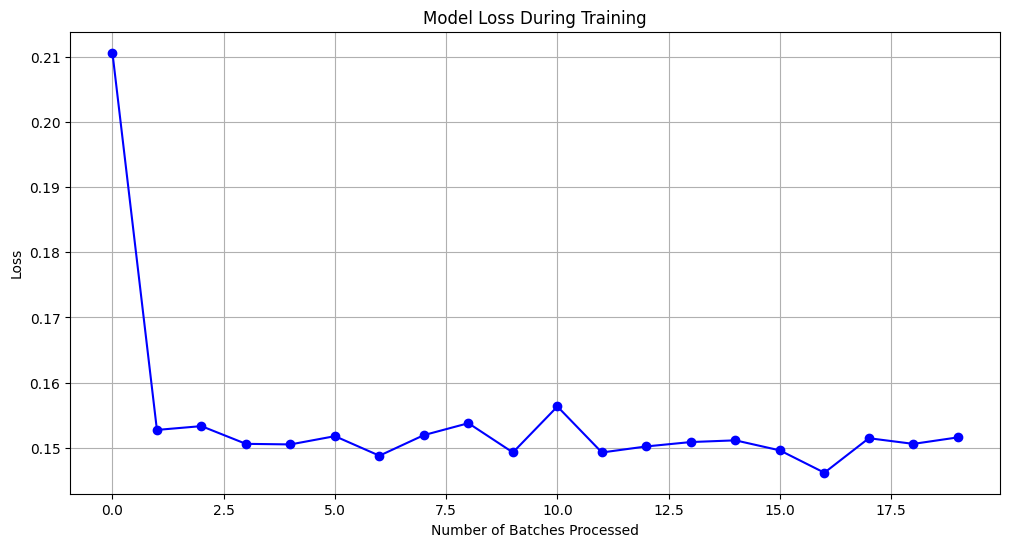

[I 2024-07-21 04:18:19,647] Trial 28 finished with value: 0.154042360726744 and parameters: {'lr': 4.959415436797416e-05, 'batch_size': 16}. Best is trial 25 with value: 0.13186235968768595.


Epoch 1, Batch 100, Partial Loss: 0.1663
Epoch 1, Batch 200, Partial Loss: 0.1549
Epoch 1, Batch 300, Partial Loss: 0.1543
Epoch 1, Batch 400, Partial Loss: 0.1537
Epoch 1, Batch 500, Partial Loss: 0.1554
Epoch 1, Batch 600, Partial Loss: 0.1487
Epoch 1, Batch 700, Partial Loss: 0.1493
Epoch 1, Batch 800, Partial Loss: 0.1507
Epoch 1, Batch 900, Partial Loss: 0.1526
Epoch 1, Batch 1000, Partial Loss: 0.1522
Epoch 1, Batch 1100, Partial Loss: 0.1540
Epoch 1, Batch 1200, Partial Loss: 0.1532
Epoch 1, Batch 1300, Partial Loss: 0.1473
Epoch 1, Batch 1400, Partial Loss: 0.1497
Epoch 1, Batch 1500, Partial Loss: 0.1493
Epoch 1, Batch 1600, Partial Loss: 0.1502
Epoch 1, Batch 1700, Partial Loss: 0.1492
Epoch 1, Batch 1800, Partial Loss: 0.1514
Epoch 1, Batch 1900, Partial Loss: 0.1506
Epoch 1, Batch 2000, Partial Loss: 0.1502
Epoch 1, Total Loss: 0.1522
Model improved and saved to /content/model/model1
EarlyStopping counter: 4 out of 10
Early stopping


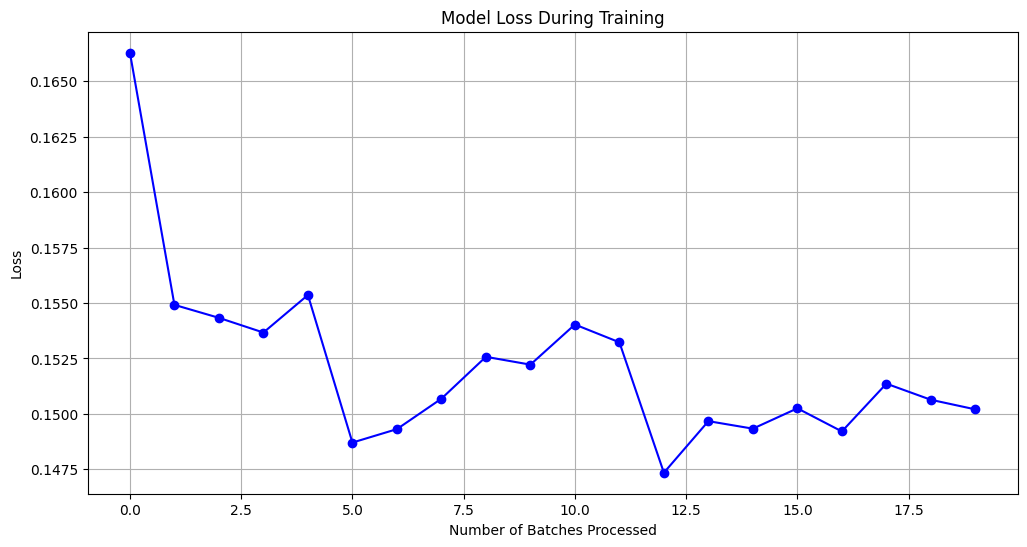

[I 2024-07-21 04:20:01,557] Trial 29 finished with value: 0.1521659436374903 and parameters: {'lr': 2.7970780392622955e-05, 'batch_size': 16}. Best is trial 25 with value: 0.13186235968768595.


Epoch 1, Batch 100, Partial Loss: 0.1430
Epoch 1, Batch 200, Partial Loss: 0.1285
Epoch 1, Batch 300, Partial Loss: 0.1272
Epoch 1, Batch 400, Partial Loss: 0.1274
Epoch 1, Batch 500, Partial Loss: 0.1248
Epoch 1, Total Loss: 0.1302
Model improved and saved to /content/model/model1
Validation loss decreased (0.131862 --> 0.130201).  Saving model ...
Early stopping


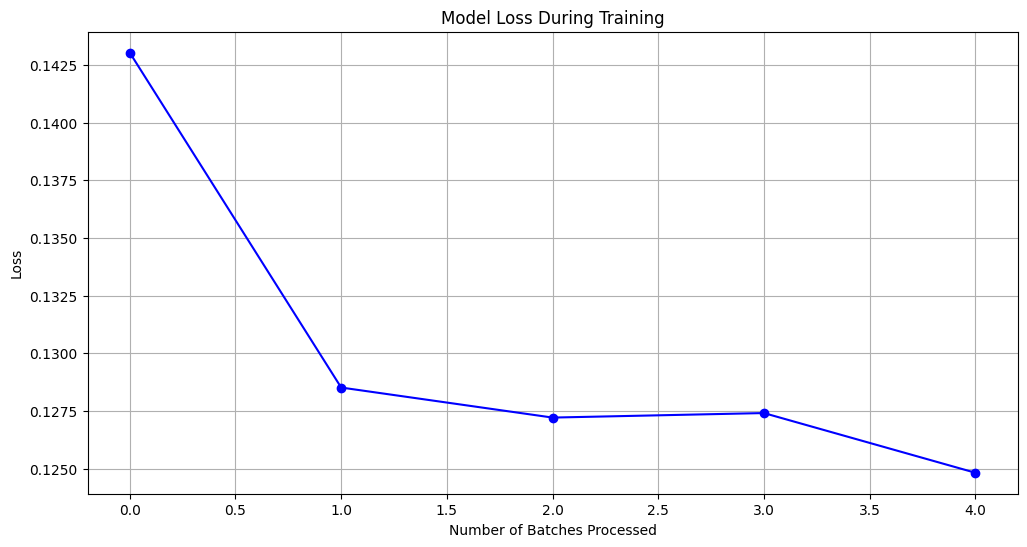

[I 2024-07-21 04:20:58,043] Trial 30 finished with value: 0.13020134899020194 and parameters: {'lr': 6.363703608580749e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1595
Epoch 1, Batch 200, Partial Loss: 0.1285
Epoch 1, Batch 300, Partial Loss: 0.1279
Epoch 1, Batch 400, Partial Loss: 0.1262
Epoch 1, Batch 500, Partial Loss: 0.1278
Epoch 1, Total Loss: 0.1340
Model improved and saved to /content/model/model1
EarlyStopping counter: 1 out of 10
Early stopping


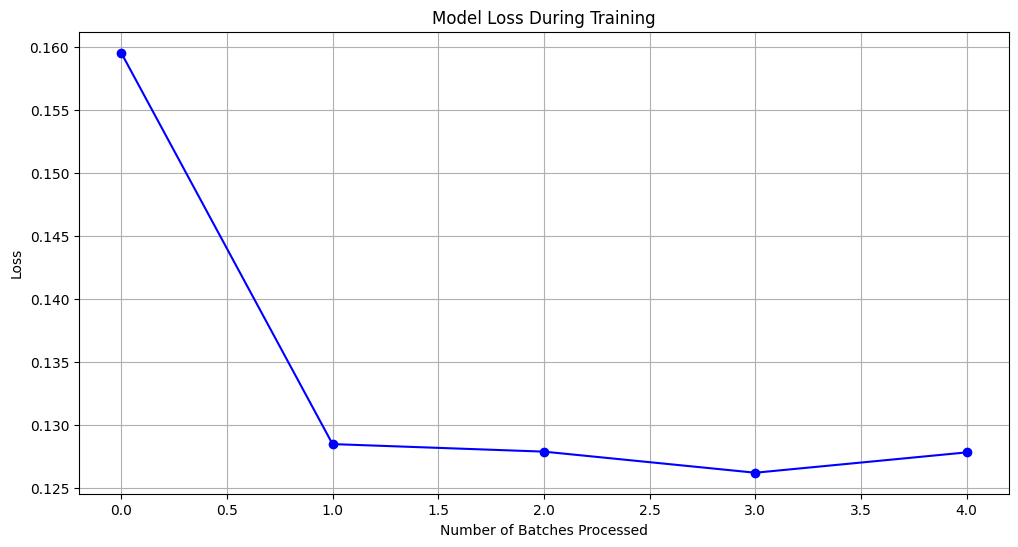

[I 2024-07-21 04:21:53,789] Trial 31 finished with value: 0.13400581899285316 and parameters: {'lr': 5.372216243545818e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1571
Epoch 1, Batch 200, Partial Loss: 0.1273
Epoch 1, Batch 300, Partial Loss: 0.1283
Epoch 1, Batch 400, Partial Loss: 0.1284
Epoch 1, Batch 500, Partial Loss: 0.1291
Epoch 1, Total Loss: 0.1340
Model improved and saved to /content/model/model1
EarlyStopping counter: 2 out of 10
Early stopping


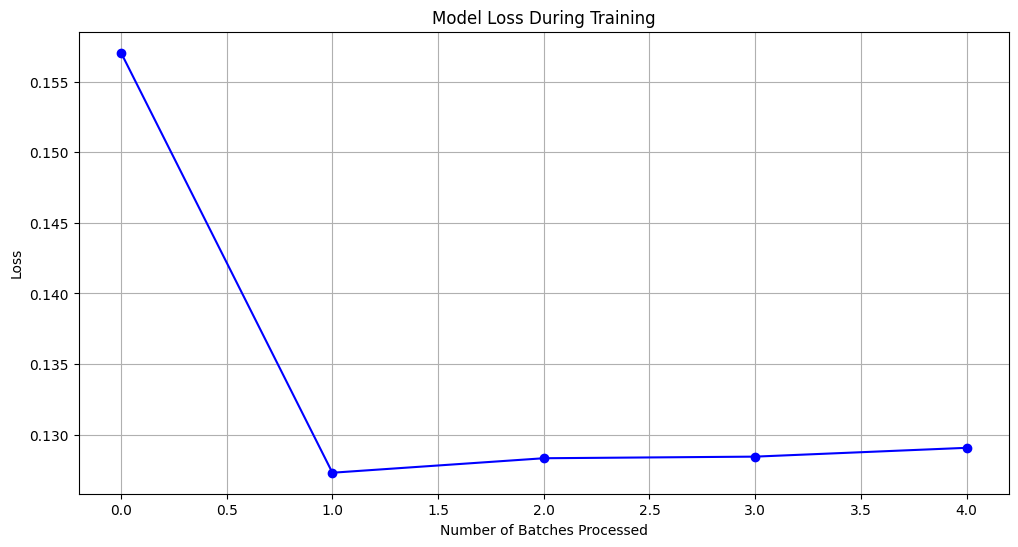

[I 2024-07-21 04:22:49,682] Trial 32 finished with value: 0.1340391211807728 and parameters: {'lr': 1.5461782751830427e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1664
Epoch 1, Batch 200, Partial Loss: 0.1277
Epoch 1, Batch 300, Partial Loss: 0.1248
Epoch 1, Batch 400, Partial Loss: 0.1273
Epoch 1, Batch 500, Partial Loss: 0.1260
Epoch 1, Total Loss: 0.1344
Model improved and saved to /content/model/model1
EarlyStopping counter: 3 out of 10
Early stopping


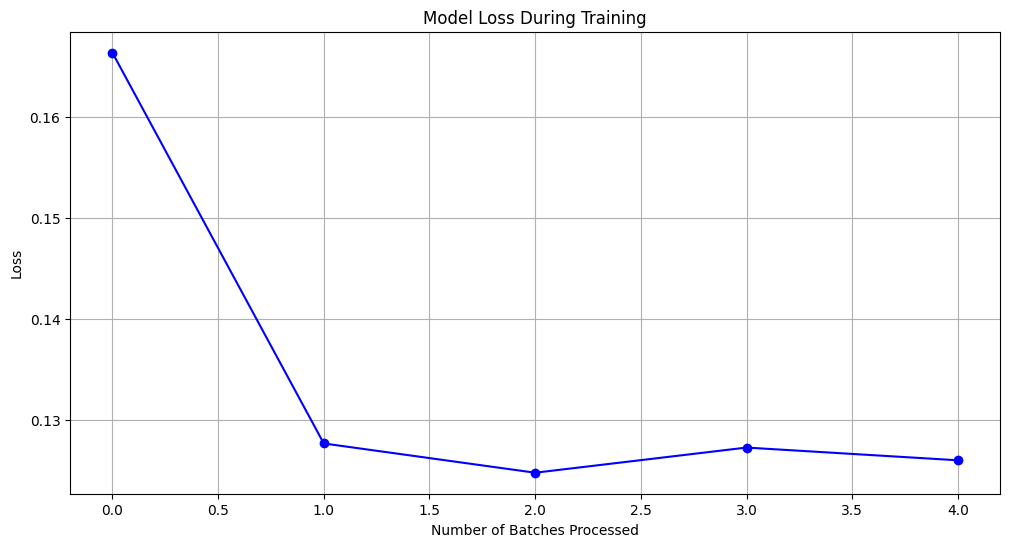

[I 2024-07-21 04:23:45,387] Trial 33 finished with value: 0.134425949126482 and parameters: {'lr': 6.739030470210933e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1912
Epoch 1, Batch 200, Partial Loss: 0.1544
Epoch 1, Batch 300, Partial Loss: 0.1519
Epoch 1, Batch 400, Partial Loss: 0.1490
Epoch 1, Batch 500, Partial Loss: 0.1519
Epoch 1, Batch 600, Partial Loss: 0.1504
Epoch 1, Batch 700, Partial Loss: 0.1544
Epoch 1, Batch 800, Partial Loss: 0.1510
Epoch 1, Batch 900, Partial Loss: 0.1495
Epoch 1, Batch 1000, Partial Loss: 0.1503
Epoch 1, Batch 1100, Partial Loss: 0.1510
Epoch 1, Batch 1200, Partial Loss: 0.1536
Epoch 1, Batch 1300, Partial Loss: 0.1531
Epoch 1, Batch 1400, Partial Loss: 0.1482
Epoch 1, Batch 1500, Partial Loss: 0.1529
Epoch 1, Batch 1600, Partial Loss: 0.1514
Epoch 1, Batch 1700, Partial Loss: 0.1499
Epoch 1, Batch 1800, Partial Loss: 0.1515
Epoch 1, Batch 1900, Partial Loss: 0.1467
Epoch 1, Batch 2000, Partial Loss: 0.1507
Epoch 1, Total Loss: 0.1531
Model improved and saved to /content/model/model1
EarlyStopping counter: 4 out of 10
Early stopping


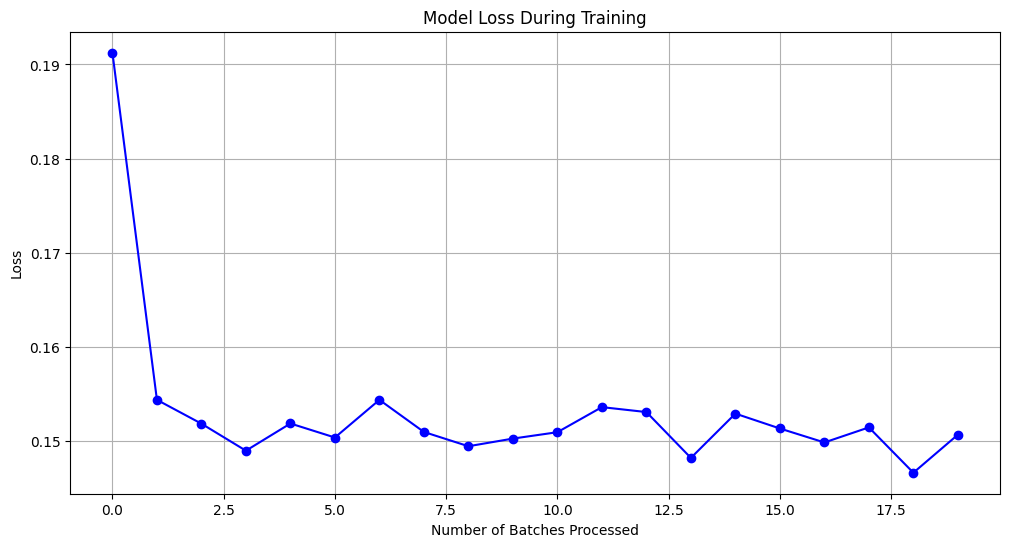

[I 2024-07-21 04:25:27,740] Trial 34 finished with value: 0.1531442252993584 and parameters: {'lr': 3.378582380245346e-05, 'batch_size': 16}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1652
Epoch 1, Batch 200, Partial Loss: 0.1313
Epoch 1, Batch 300, Partial Loss: 0.1278
Epoch 1, Batch 400, Partial Loss: 0.1271
Epoch 1, Batch 500, Partial Loss: 0.1281
Epoch 1, Total Loss: 0.1359
Model improved and saved to /content/model/model1
EarlyStopping counter: 5 out of 10
Early stopping


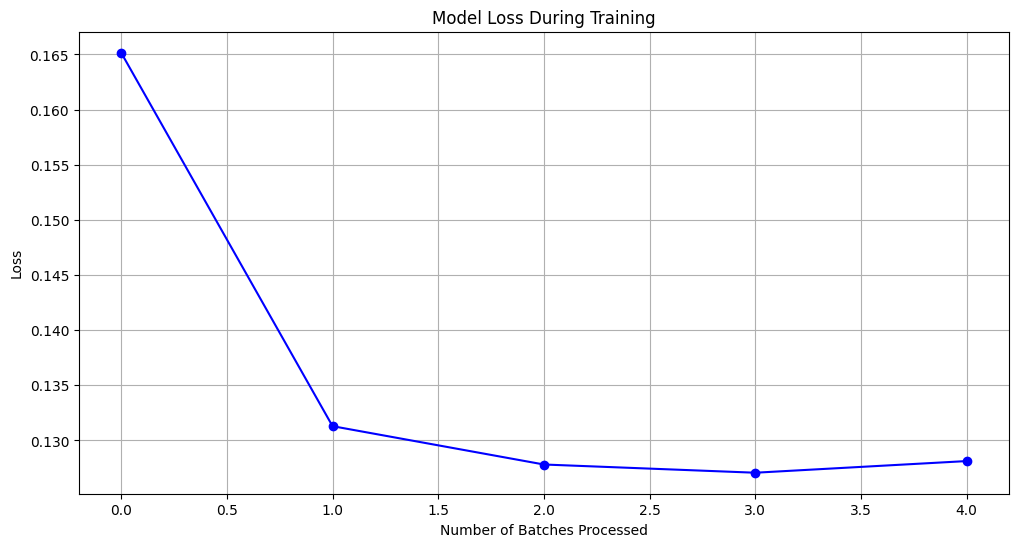

[I 2024-07-21 04:26:23,575] Trial 35 finished with value: 0.13589736445248124 and parameters: {'lr': 1.7560823645487796e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1751
Epoch 1, Batch 200, Partial Loss: 0.1273
Epoch 1, Batch 300, Partial Loss: 0.1270
Epoch 1, Batch 400, Partial Loss: 0.1272
Epoch 1, Batch 500, Partial Loss: 0.1250
Epoch 1, Total Loss: 0.1363
Model improved and saved to /content/model/model1
EarlyStopping counter: 6 out of 10
Early stopping


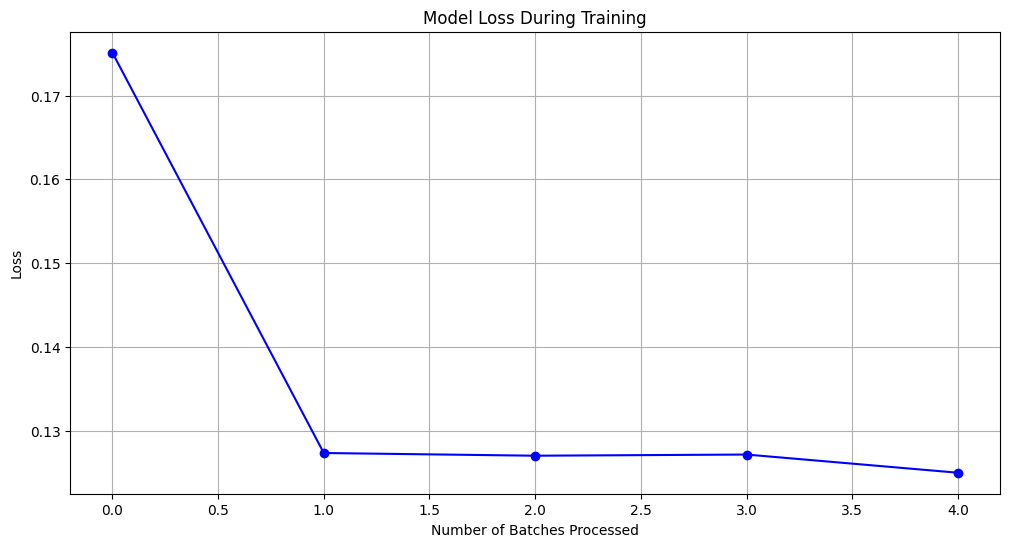

[I 2024-07-21 04:27:19,408] Trial 36 finished with value: 0.1363206812888384 and parameters: {'lr': 6.0066542456968e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1688
Epoch 1, Batch 200, Partial Loss: 0.1265
Epoch 1, Batch 300, Partial Loss: 0.1268
Epoch 1, Batch 400, Partial Loss: 0.1283
Epoch 1, Batch 500, Partial Loss: 0.1296
Epoch 1, Total Loss: 0.1360
Model improved and saved to /content/model/model1
EarlyStopping counter: 7 out of 10
Early stopping


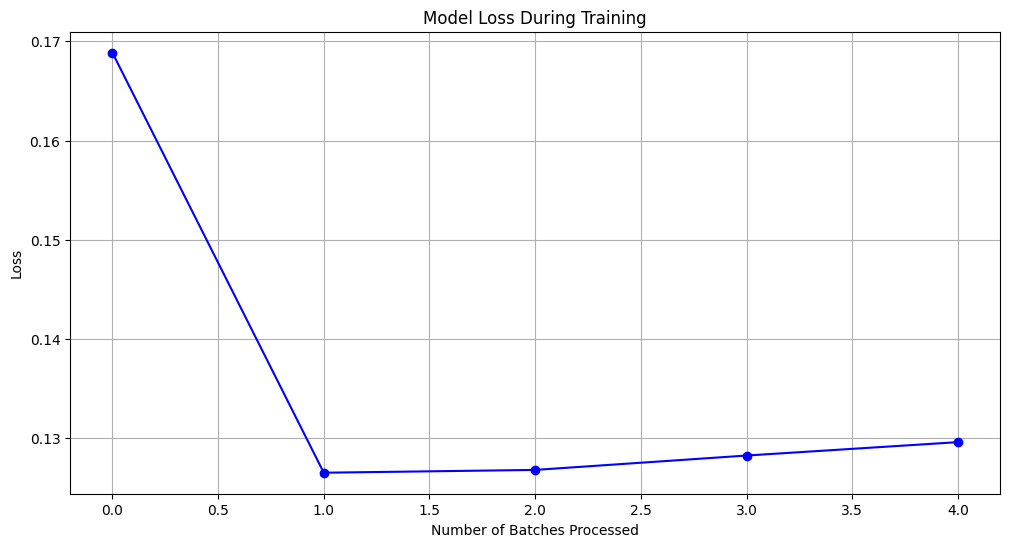

[I 2024-07-21 04:28:15,391] Trial 37 finished with value: 0.1360177416652441 and parameters: {'lr': 2.8946680794313485e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1938
Epoch 1, Batch 200, Partial Loss: 0.1539
Epoch 1, Batch 300, Partial Loss: 0.1536
Epoch 1, Batch 400, Partial Loss: 0.1566
Epoch 1, Batch 500, Partial Loss: 0.1527
Epoch 1, Batch 600, Partial Loss: 0.1530
Epoch 1, Batch 700, Partial Loss: 0.1478
Epoch 1, Batch 800, Partial Loss: 0.1464
Epoch 1, Batch 900, Partial Loss: 0.1537
Epoch 1, Batch 1000, Partial Loss: 0.1524
Epoch 1, Batch 1100, Partial Loss: 0.1502
Epoch 1, Batch 1200, Partial Loss: 0.1462
Epoch 1, Batch 1300, Partial Loss: 0.1501
Epoch 1, Batch 1400, Partial Loss: 0.1507
Epoch 1, Batch 1500, Partial Loss: 0.1500
Epoch 1, Batch 1600, Partial Loss: 0.1477
Epoch 1, Batch 1700, Partial Loss: 0.1521
Epoch 1, Batch 1800, Partial Loss: 0.1508
Epoch 1, Batch 1900, Partial Loss: 0.1489
Epoch 1, Batch 2000, Partial Loss: 0.1502
Epoch 1, Total Loss: 0.1530
Model improved and saved to /content/model/model1
EarlyStopping counter: 8 out of 10
Early stopping


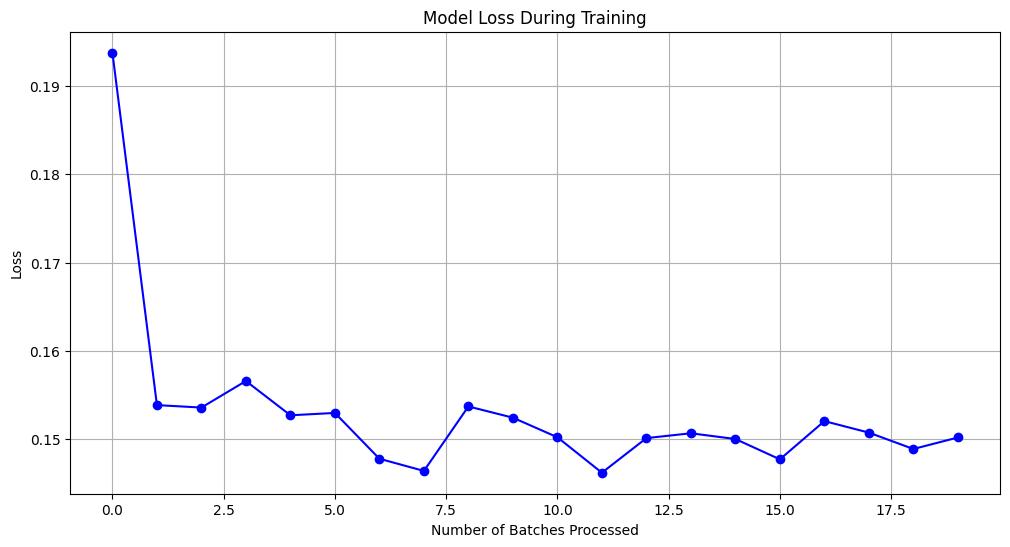

[I 2024-07-21 04:29:58,699] Trial 38 finished with value: 0.1530424398817122 and parameters: {'lr': 3.5059331708081254e-05, 'batch_size': 16}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 1.0725
Epoch 1, Batch 200, Partial Loss: 0.7139
Epoch 1, Batch 300, Partial Loss: 0.7072
Epoch 1, Batch 400, Partial Loss: 0.6948
Epoch 1, Batch 500, Partial Loss: 0.6936
Epoch 1, Total Loss: 0.7764
Model improved and saved to /content/model/model1
EarlyStopping counter: 9 out of 10
Early stopping


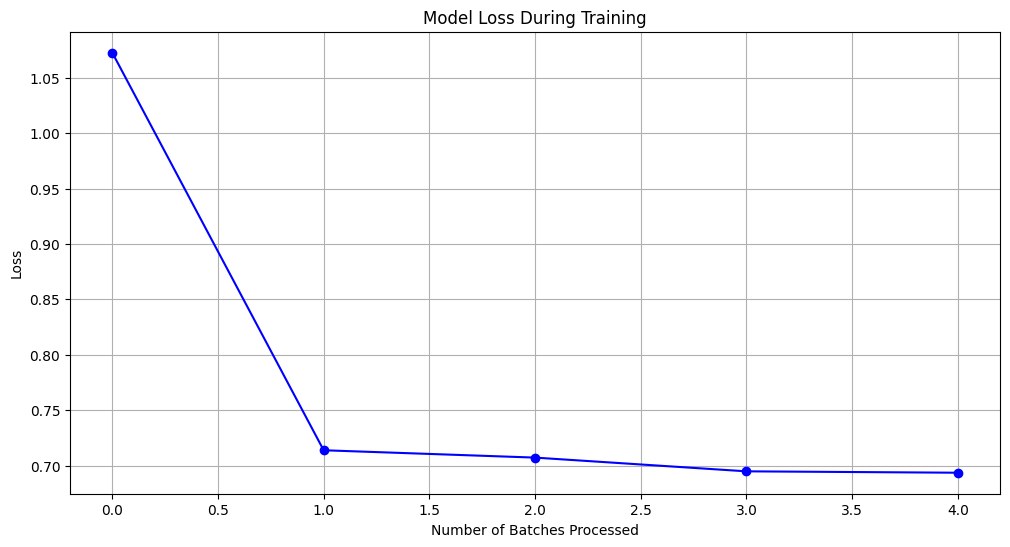

[I 2024-07-21 04:30:54,689] Trial 39 finished with value: 0.7764013245105743 and parameters: {'lr': 0.00978094531709083, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1544
Epoch 1, Batch 200, Partial Loss: 0.1304
Epoch 1, Batch 300, Partial Loss: 0.1287
Epoch 1, Batch 400, Partial Loss: 0.1252
Epoch 1, Batch 500, Partial Loss: 0.1259
Epoch 1, Total Loss: 0.1329
Model improved and saved to /content/model/model1
EarlyStopping counter: 10 out of 10
Early stopping


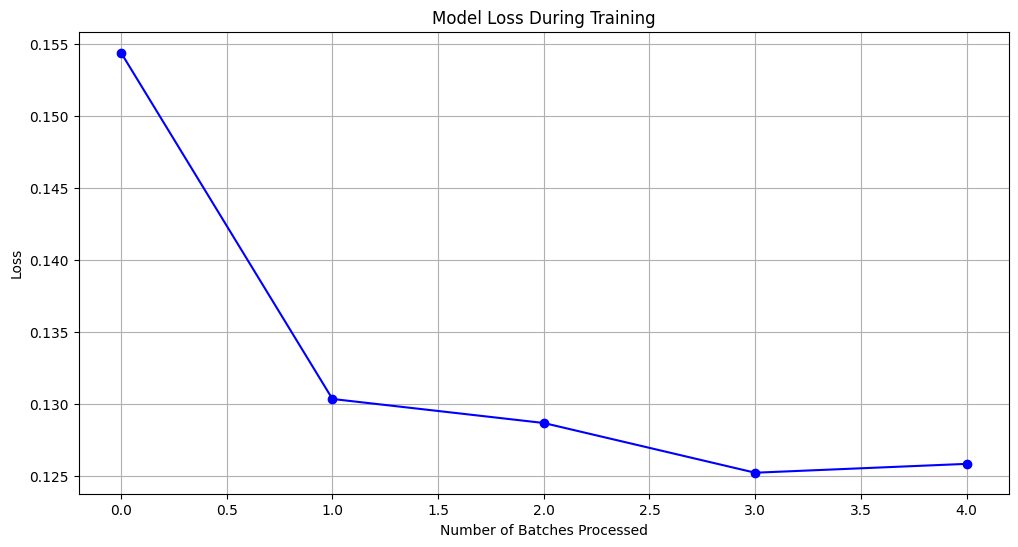

[I 2024-07-21 04:31:50,794] Trial 40 finished with value: 0.13290915995836258 and parameters: {'lr': 1.507325769997842e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1602
Epoch 1, Batch 200, Partial Loss: 0.1291
Epoch 1, Batch 300, Partial Loss: 0.1276
Epoch 1, Batch 400, Partial Loss: 0.1283
Epoch 1, Batch 500, Partial Loss: 0.1262
Epoch 1, Total Loss: 0.1343
Model improved and saved to /content/model/model1
EarlyStopping counter: 11 out of 10
Early stopping


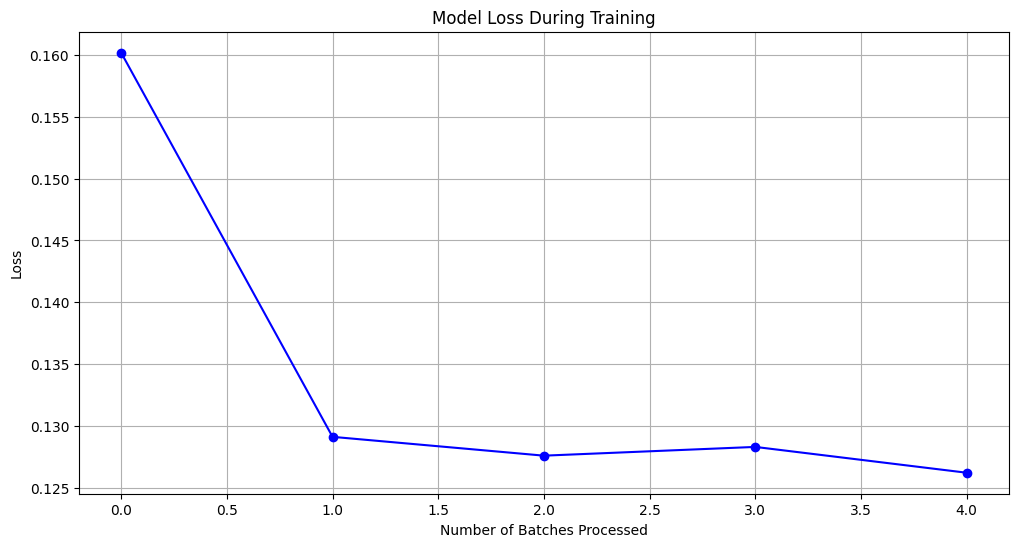

[I 2024-07-21 04:32:46,822] Trial 41 finished with value: 0.1342770702689886 and parameters: {'lr': 1.4522788691013422e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1584
Epoch 1, Batch 200, Partial Loss: 0.1271
Epoch 1, Batch 300, Partial Loss: 0.1282
Epoch 1, Batch 400, Partial Loss: 0.1264
Epoch 1, Batch 500, Partial Loss: 0.1290
Epoch 1, Total Loss: 0.1338
Model improved and saved to /content/model/model1
EarlyStopping counter: 12 out of 10
Early stopping


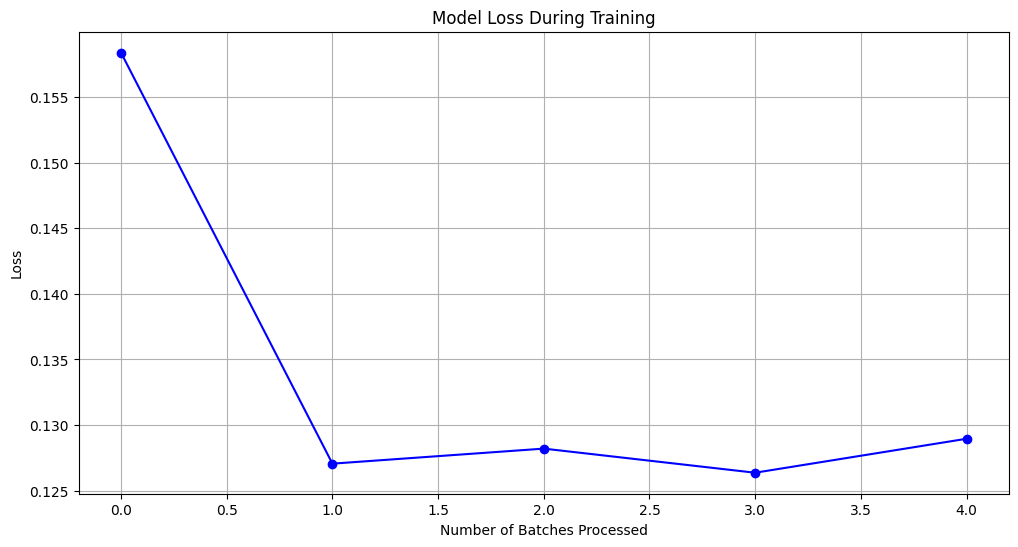

[I 2024-07-21 04:33:42,837] Trial 42 finished with value: 0.13379402796924114 and parameters: {'lr': 2.0855306025835575e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1621
Epoch 1, Batch 200, Partial Loss: 0.1284
Epoch 1, Batch 300, Partial Loss: 0.1274
Epoch 1, Batch 400, Partial Loss: 0.1275
Epoch 1, Batch 500, Partial Loss: 0.1258
Epoch 1, Total Loss: 0.1342
Model improved and saved to /content/model/model1
EarlyStopping counter: 13 out of 10
Early stopping


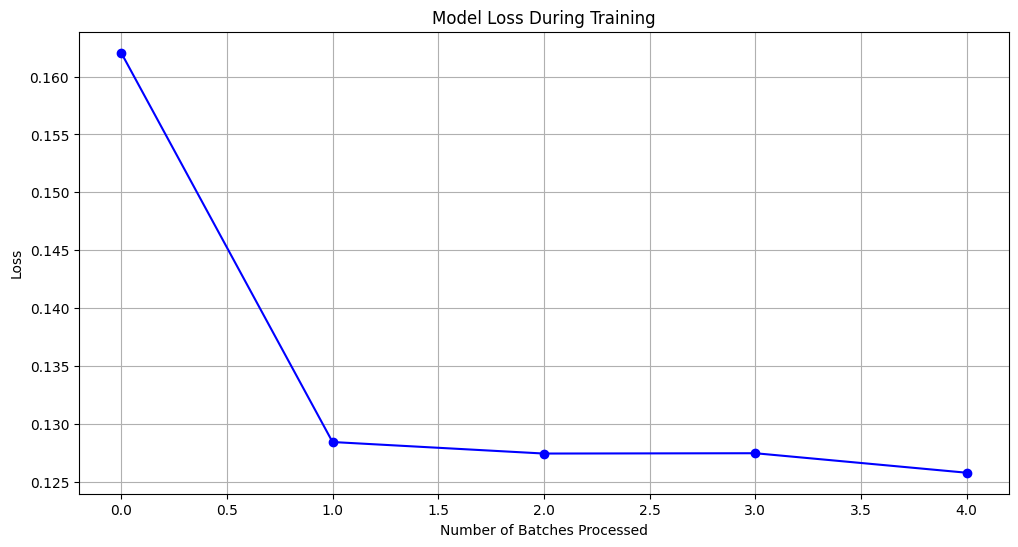

[I 2024-07-21 04:34:38,884] Trial 43 finished with value: 0.13422780667245388 and parameters: {'lr': 4.123997580296213e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1696
Epoch 1, Batch 200, Partial Loss: 0.1277
Epoch 1, Batch 300, Partial Loss: 0.1273
Epoch 1, Batch 400, Partial Loss: 0.1285
Epoch 1, Batch 500, Partial Loss: 0.1268
Epoch 1, Total Loss: 0.1360
Model improved and saved to /content/model/model1
EarlyStopping counter: 14 out of 10
Early stopping


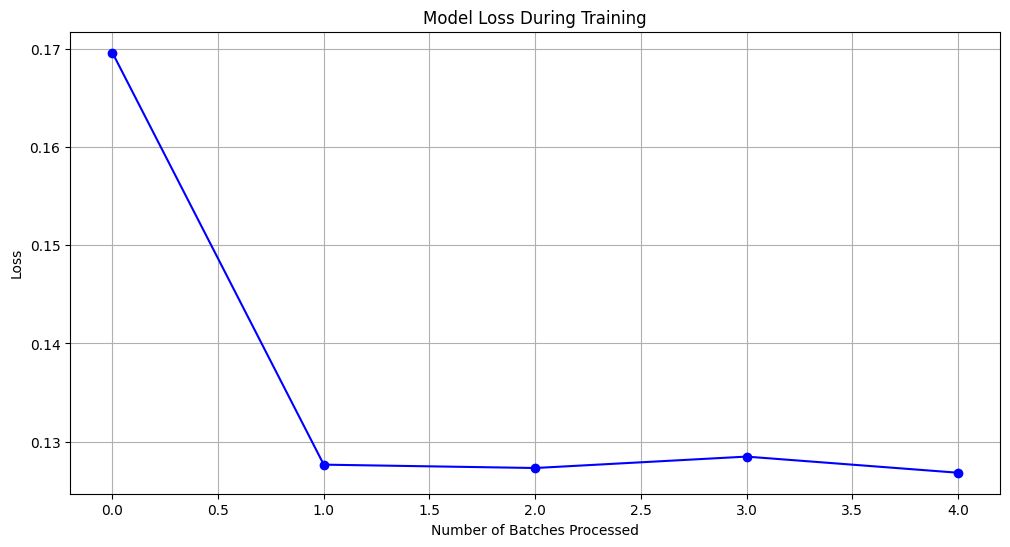

[I 2024-07-21 04:35:35,184] Trial 44 finished with value: 0.1359793957769871 and parameters: {'lr': 1.0956021623276322e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.9094
Epoch 1, Batch 200, Partial Loss: 0.7068
Epoch 1, Batch 300, Partial Loss: 0.7083
Epoch 1, Batch 400, Partial Loss: 0.7004
Epoch 1, Batch 500, Partial Loss: 0.6977
Epoch 1, Total Loss: 0.7445
Model improved and saved to /content/model/model1
EarlyStopping counter: 15 out of 10
Early stopping


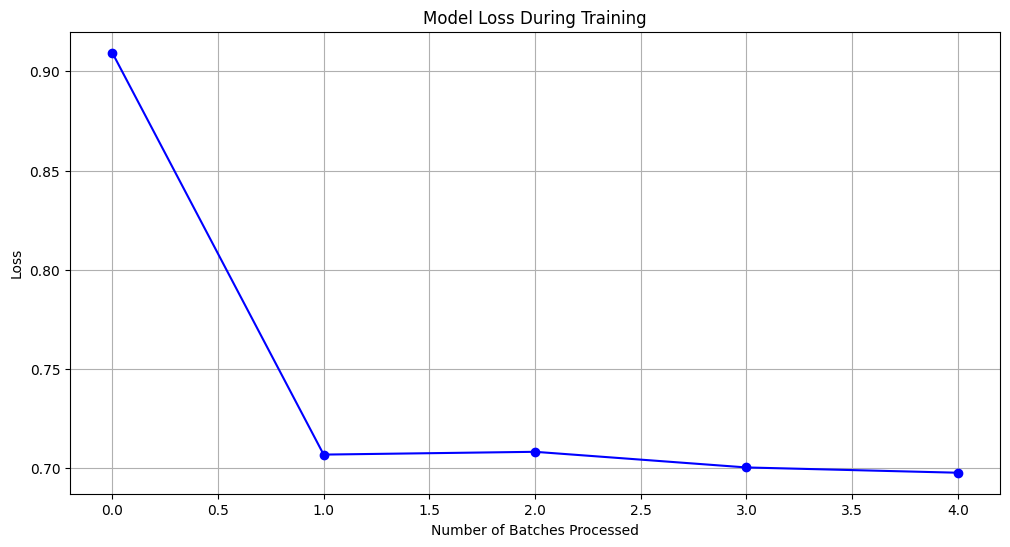

[I 2024-07-21 04:36:31,301] Trial 45 finished with value: 0.7445090011358261 and parameters: {'lr': 0.0034907996948861752, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1585
Epoch 1, Batch 200, Partial Loss: 0.1298
Epoch 1, Batch 300, Partial Loss: 0.1284
Epoch 1, Batch 400, Partial Loss: 0.1255
Epoch 1, Batch 500, Partial Loss: 0.1282
Epoch 1, Total Loss: 0.1341
Model improved and saved to /content/model/model1
EarlyStopping counter: 16 out of 10
Early stopping


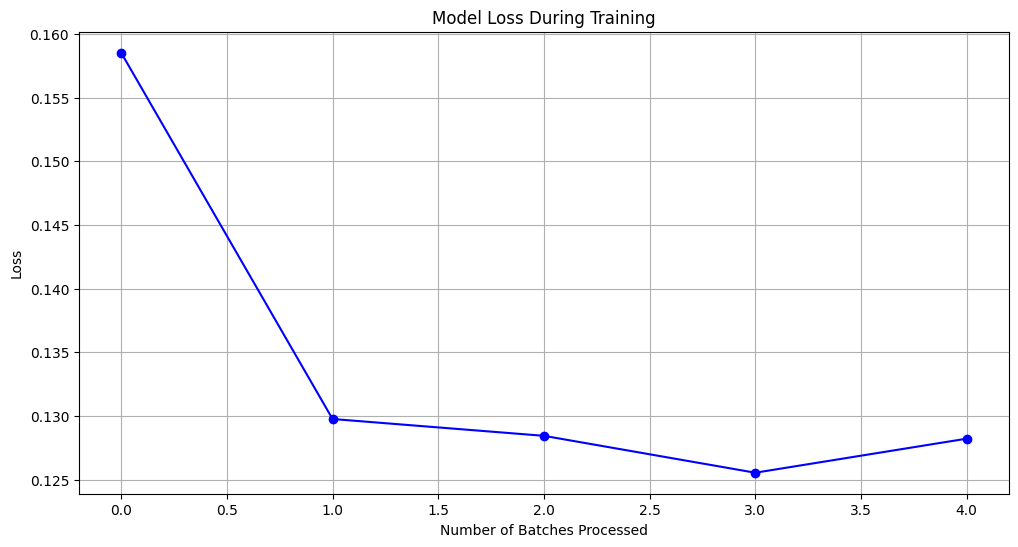

[I 2024-07-21 04:37:27,393] Trial 46 finished with value: 0.13409228140115736 and parameters: {'lr': 1.3855901789253303e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1726
Epoch 1, Batch 200, Partial Loss: 0.1271
Epoch 1, Batch 300, Partial Loss: 0.1263
Epoch 1, Batch 400, Partial Loss: 0.1291
Epoch 1, Batch 500, Partial Loss: 0.1254
Epoch 1, Total Loss: 0.1361
Model improved and saved to /content/model/model1
EarlyStopping counter: 17 out of 10
Early stopping


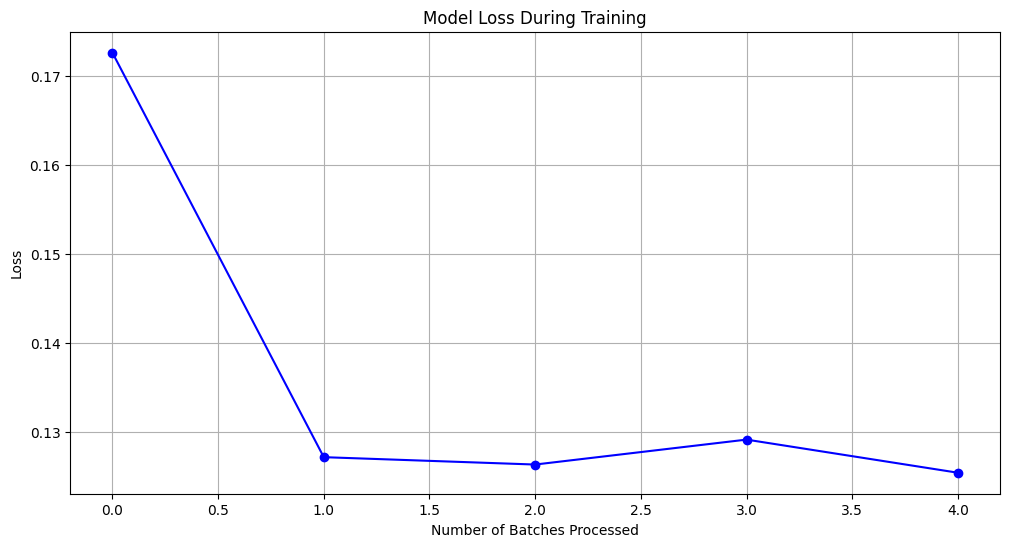

[I 2024-07-21 04:38:23,476] Trial 47 finished with value: 0.13610769861936572 and parameters: {'lr': 8.125292151521703e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1949
Epoch 1, Batch 200, Partial Loss: 0.1524
Epoch 1, Batch 300, Partial Loss: 0.1558
Epoch 1, Batch 400, Partial Loss: 0.1538
Epoch 1, Batch 500, Partial Loss: 0.1511
Epoch 1, Batch 600, Partial Loss: 0.1516
Epoch 1, Batch 700, Partial Loss: 0.1485
Epoch 1, Batch 800, Partial Loss: 0.1494
Epoch 1, Batch 900, Partial Loss: 0.1509
Epoch 1, Batch 1000, Partial Loss: 0.1489
Epoch 1, Batch 1100, Partial Loss: 0.1510
Epoch 1, Batch 1200, Partial Loss: 0.1486
Epoch 1, Batch 1300, Partial Loss: 0.1530
Epoch 1, Batch 1400, Partial Loss: 0.1505
Epoch 1, Batch 1500, Partial Loss: 0.1555
Epoch 1, Batch 1600, Partial Loss: 0.1494
Epoch 1, Batch 1700, Partial Loss: 0.1513
Epoch 1, Batch 1800, Partial Loss: 0.1551
Epoch 1, Batch 1900, Partial Loss: 0.1529
Epoch 1, Batch 2000, Partial Loss: 0.1517
Epoch 1, Total Loss: 0.1538
Model improved and saved to /content/model/model1
EarlyStopping counter: 18 out of 10
Early stopping


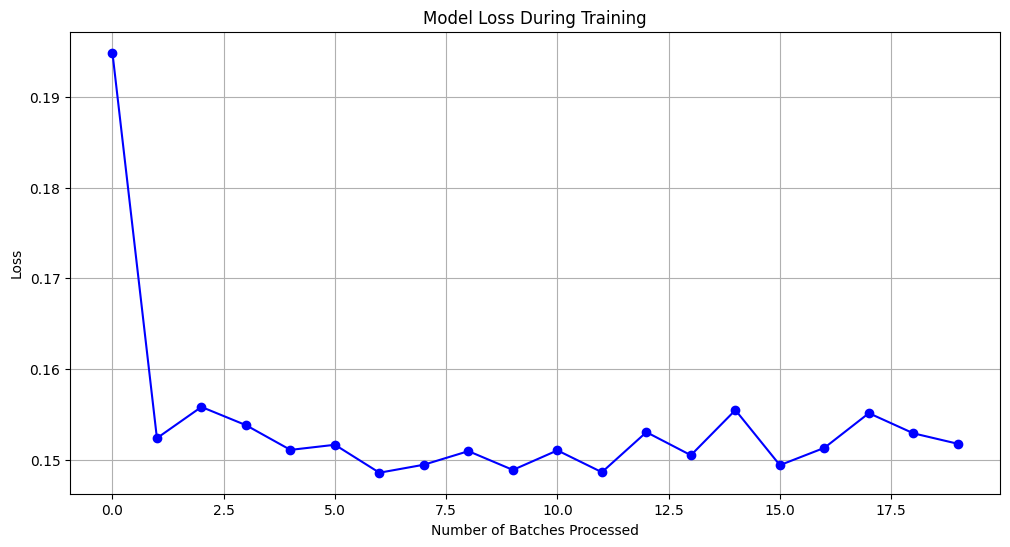

[I 2024-07-21 04:40:07,959] Trial 48 finished with value: 0.15381193108111618 and parameters: {'lr': 1.9516998688120074e-05, 'batch_size': 16}. Best is trial 30 with value: 0.13020134899020194.


Epoch 1, Batch 100, Partial Loss: 0.1476
Epoch 1, Batch 200, Partial Loss: 0.1266
Epoch 1, Batch 300, Partial Loss: 0.1290
Epoch 1, Batch 400, Partial Loss: 0.1279
Epoch 1, Batch 500, Partial Loss: 0.1260
Epoch 1, Total Loss: 0.1314
Model improved and saved to /content/model/model1
EarlyStopping counter: 19 out of 10
Early stopping


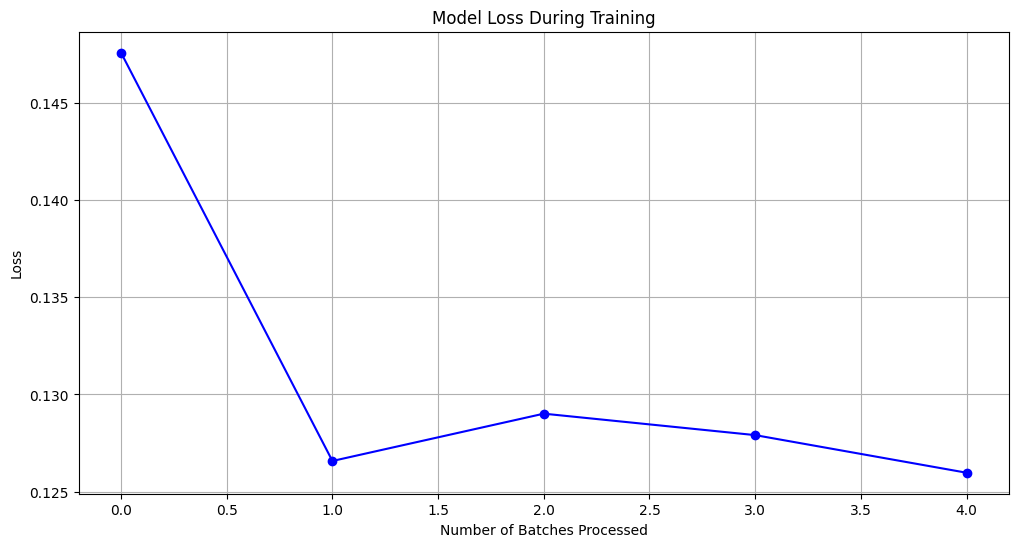

[I 2024-07-21 04:41:03,999] Trial 49 finished with value: 0.13141039580106736 and parameters: {'lr': 4.7927519572156665e-05, 'batch_size': 64}. Best is trial 30 with value: 0.13020134899020194.


Best trial results: Value (loss): 0.13020134899020194
Best hyperparameters:
  lr: 6.363703608580749e-05
  batch_size: 64


In [78]:
# find params
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_trial = study.best_trial
print(f"Best trial results: Value (loss): {best_trial.value}")
print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

batch_size = best_trial.params['batch_size']
lr = best_trial.params['lr']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VLM(len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()


In [79]:
print(best_trial)

FrozenTrial(number=30, state=TrialState.COMPLETE, values=[0.13020134899020194], datetime_start=datetime.datetime(2024, 7, 21, 4, 20, 1, 559551), datetime_complete=datetime.datetime(2024, 7, 21, 4, 20, 58, 42949), params={'lr': 6.363703608580749e-05, 'batch_size': 64}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=30, value=None)


In [80]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 6.363703608580749e-05
    maximize: False
    weight_decay: 0
)


Epoch 1, Batch 100, Partial Loss: 0.1825
Epoch 1, Batch 200, Partial Loss: 0.1281
Epoch 1, Batch 300, Partial Loss: 0.1268
Epoch 1, Batch 400, Partial Loss: 0.1256
Epoch 1, Batch 500, Partial Loss: 0.1271
Epoch 1, Total Loss: 0.1380
Model improved and saved to /content/model/model1
EarlyStopping counter: 20 out of 10
Early stopping


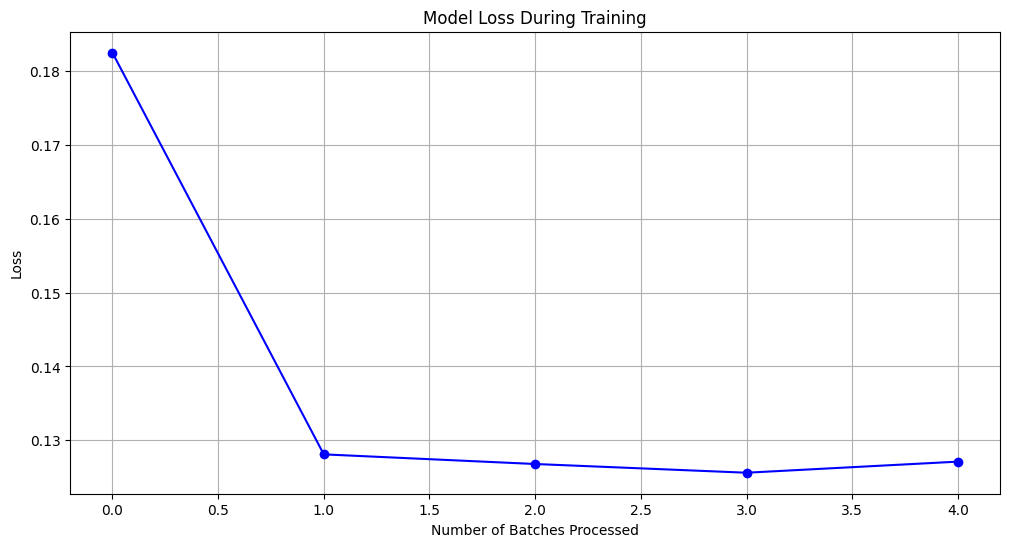

0.13800972937047482

In [81]:
epochs = 10
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
train(model, device, train_loader, optimizer, criterion, epochs, scheduler, save_path='/content/model/model1')

In [82]:
load_and_test(model, device, test_loader, criterion, '/content/model/model1')

Test Loss: 0.1213


In [77]:
adversarial_training(model, device, val_loader, test_loader, optimizer, criterion, epsilon=0.9)

Output grad_fn: <ViewBackward0 object at 0x7e3b647fcc70>
Epoch 1, Loss: 0.12671597301959991
Output grad_fn: <ViewBackward0 object at 0x7e3b647feda0>
Epoch 1, Loss: 0.13281641900539398
Output grad_fn: <ViewBackward0 object at 0x7e3b647fe590>
Epoch 1, Loss: 0.13650335371494293
Output grad_fn: <ViewBackward0 object at 0x7e3c95fb1090>
Epoch 1, Loss: 0.13730911910533905
Output grad_fn: <ViewBackward0 object at 0x7e3bbf65f3d0>
Epoch 1, Loss: 0.15240442752838135
Output grad_fn: <ViewBackward0 object at 0x7e3bbf65f3d0>
Epoch 1, Loss: 0.11255686730146408
Output grad_fn: <ViewBackward0 object at 0x7e3bbf65f3d0>
Epoch 1, Loss: 0.12048875540494919
Output grad_fn: <ViewBackward0 object at 0x7e3c95fb0be0>
Epoch 1, Loss: 0.09093019366264343
Output grad_fn: <ViewBackward0 object at 0x7e3c95fb0be0>
Epoch 1, Loss: 0.14130717515945435
Output grad_fn: <ViewBackward0 object at 0x7e3bbf65f3d0>
Epoch 1, Loss: 0.12803415954113007
Output grad_fn: <ViewBackward0 object at 0x7e3bbf65f3d0>
Epoch 1, Loss: 0.128057

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
